# SUV Purchase Predictor

In this notebook, we will train a logistic regression model to predict whether or not one should buy an SUV given their age, gender, and annual salary.

## Introduction
Suppose you are thinking about buying an SUV, however you are not sure whether or not you should drop the money on a new car. You decide to make a classifier that learns people's decisions in the past to aid you in your own decision.

## Unpacking the dataset

In [1]:
import numpy as np
import pandas as pd
import torch

pd.set_option("display.max_columns", None)

In [2]:
data = pd.read_csv('datasets/SUV_Purchase.csv')
data

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [3]:
gender_dummies = pd.get_dummies(data['Gender'])
gender_dummies

,Female,Male
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
395,1,0
396,0,1
397,1,0
398,0,1


In [4]:
data['gender_num'] = gender_dummies['Female']
data

,User ID,Gender,Age,EstimatedSalary,Purchased,gender_num
0,15624510,Male,19,19000,0,0
1,15810944,Male,35,20000,0,0
2,15668575,Female,26,43000,0,1
3,15603246,Female,27,57000,0,1
4,15804002,Male,19,76000,0,0
...,...,...,...,...,...,...
395,15691863,Female,46,41000,1,1
396,15706071,Male,51,23000,1,0
397,15654296,Female,50,20000,1,1
398,15755018,Male,36,33000,0,0


In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

features = data[['Age', 'EstimatedSalary', 'gender_num']].to_numpy()
labels = data[['Purchased']].to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.2)
poly= PolynomialFeatures(degree=3)


X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

X_train_t = torch.from_numpy(X_train).float()
Y_train_t = torch.from_numpy(Y_train).float()

(320, 20)
(320, 1)
(80, 20)
(80, 1)


In [6]:
positives = np.sum(data['Purchased'].to_numpy())
negatives = int(len(data.index) - positives)

print(f'Num of positives: {positives}')
print(f'Num of negatives: {negatives}\n')

pos_weight = len(data.index)/(2 * positives)
neg_weight = len(data.index)/(2 * negatives)

print(f"positive weight: {pos_weight}")
print(f"negative weight: {neg_weight}")

def class_weights(Y_train, pos_weight, neg_weight):
    pos_mask = Y_train.astype(bool)
    neg_mask = ~Y_train.astype(bool)

    pos_mask = pos_mask.astype(np.float32) * pos_weight

    neg_mask = neg_mask.astype(np.float32) * neg_weight
    return pos_mask + neg_mask
    

weights = class_weights(Y_train, pos_weight, neg_weight)
print(weights.shape)

Num of positives: 143
Num of negatives: 257

positive weight: 1.3986013986013985
negative weight: 0.7782101167315175
(320, 1)


## Training the Logistic Regression Model

In [7]:
from torch.nn import Module, Linear, BCELoss, BatchNorm1d
from torch.optim import SGD
from torch.autograd import Variable

class Logreg(Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear  = Linear(input_dim, output_dim)
        self.bn = BatchNorm1d(input_dim)
        
    def forward(self, x):
        x = self.bn(x)
        z = self.linear(x)
        y_pred = torch.sigmoid(z)
        return y_pred
    
    def fit(self, X_train, Y_train, epochs, loss_func, opt):
        for i in range(epochs):
            self.train()
            opt.zero_grad()
        
            Y_pred = self(X_train)
            loss = loss_func(Y_pred, Y_train)
            
            print(f"iteration {i+1}: loss: {loss.item()}")
        
            loss.backward()
            opt.step()

In [8]:
LEARNING_RATE = 0.02
EPOCHS = 50000

model = Logreg(X_train.shape[1], 1)

criterion = BCELoss(weight=torch.from_numpy(weights).float())
optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True)

if __name__ == "__main__":
    model.fit(X_train_t, Y_train_t, EPOCHS, criterion, optimizer)

iteration 1: loss: 0.5495964288711548
iteration 2: loss: 0.5398604273796082
iteration 3: loss: 0.5270079374313354
iteration 4: loss: 0.5122028589248657
iteration 5: loss: 0.49644604325294495
iteration 6: loss: 0.48052436113357544
iteration 7: loss: 0.46500855684280396
iteration 8: loss: 0.4502794146537781
iteration 9: loss: 0.4365650713443756
iteration 10: loss: 0.4239792823791504
iteration 11: loss: 0.41255468130111694
iteration 12: loss: 0.40226978063583374
iteration 13: loss: 0.3930688798427582
iteration 14: loss: 0.38487696647644043
iteration 15: loss: 0.3776097595691681
iteration 16: loss: 0.37118032574653625
iteration 17: loss: 0.3655037581920624
iteration 18: loss: 0.3604995310306549
iteration 19: loss: 0.35609281063079834
iteration 20: loss: 0.3522152304649353
iteration 21: loss: 0.3488048315048218
iteration 22: loss: 0.34580594301223755
iteration 23: loss: 0.3431687653064728
iteration 24: loss: 0.34084898233413696
iteration 25: loss: 0.33880719542503357
iteration 26: loss: 0.3

iteration 272: loss: 0.28205379843711853
iteration 273: loss: 0.2819565236568451
iteration 274: loss: 0.28185930848121643
iteration 275: loss: 0.2817629873752594
iteration 276: loss: 0.28166717290878296
iteration 277: loss: 0.28157153725624084
iteration 278: loss: 0.28147634863853455
iteration 279: loss: 0.2813819944858551
iteration 280: loss: 0.2812877297401428
iteration 281: loss: 0.28119391202926636
iteration 282: loss: 0.2811005711555481
iteration 283: loss: 0.2810077667236328
iteration 284: loss: 0.28091534972190857
iteration 285: loss: 0.28082314133644104
iteration 286: loss: 0.2807317078113556
iteration 287: loss: 0.2806406617164612
iteration 288: loss: 0.2805498242378235
iteration 289: loss: 0.2804597020149231
iteration 290: loss: 0.28036952018737793
iteration 291: loss: 0.28028005361557007
iteration 292: loss: 0.28019094467163086
iteration 293: loss: 0.28010234236717224
iteration 294: loss: 0.28001412749290466
iteration 295: loss: 0.2799264192581177
iteration 296: loss: 0.2798

iteration 565: loss: 0.266132652759552
iteration 566: loss: 0.26610350608825684
iteration 567: loss: 0.266074001789093
iteration 568: loss: 0.26604512333869934
iteration 569: loss: 0.26601630449295044
iteration 570: loss: 0.2659870982170105
iteration 571: loss: 0.2659584581851959
iteration 572: loss: 0.2659294009208679
iteration 573: loss: 0.26590055227279663
iteration 574: loss: 0.26587218046188354
iteration 575: loss: 0.26584354043006897
iteration 576: loss: 0.265814870595932
iteration 577: loss: 0.265786349773407
iteration 578: loss: 0.26575833559036255
iteration 579: loss: 0.26573002338409424
iteration 580: loss: 0.2657017409801483
iteration 581: loss: 0.26567357778549194
iteration 582: loss: 0.2656455338001251
iteration 583: loss: 0.2656175494194031
iteration 584: loss: 0.2655896246433258
iteration 585: loss: 0.2655617594718933
iteration 586: loss: 0.26553404331207275
iteration 587: loss: 0.26550641655921936
iteration 588: loss: 0.2654789090156555
iteration 589: loss: 0.2654514014

iteration 914: loss: 0.2585245966911316
iteration 915: loss: 0.25850656628608704
iteration 916: loss: 0.2584885358810425
iteration 917: loss: 0.25847095251083374
iteration 918: loss: 0.2584529519081116
iteration 919: loss: 0.2584350109100342
iteration 920: loss: 0.2584170699119568
iteration 921: loss: 0.2583991289138794
iteration 922: loss: 0.2583812475204468
iteration 923: loss: 0.25836336612701416
iteration 924: loss: 0.25834551453590393
iteration 925: loss: 0.25832730531692505
iteration 926: loss: 0.258309543132782
iteration 927: loss: 0.25829172134399414
iteration 928: loss: 0.2582739293575287
iteration 929: loss: 0.2582561671733856
iteration 930: loss: 0.25823846459388733
iteration 931: loss: 0.258220374584198
iteration 932: loss: 0.2582026720046997
iteration 933: loss: 0.2581849992275238
iteration 934: loss: 0.25816696882247925
iteration 935: loss: 0.25814953446388245
iteration 936: loss: 0.25813189148902893
iteration 937: loss: 0.25811392068862915
iteration 938: loss: 0.25809636

iteration 1220: loss: 0.25349903106689453
iteration 1221: loss: 0.25348418951034546
iteration 1222: loss: 0.25346916913986206
iteration 1223: loss: 0.25345438718795776
iteration 1224: loss: 0.25343939661979675
iteration 1225: loss: 0.25342461466789246
iteration 1226: loss: 0.2534096837043762
iteration 1227: loss: 0.2533946633338928
iteration 1228: loss: 0.25338008999824524
iteration 1229: loss: 0.2533651292324066
iteration 1230: loss: 0.25335025787353516
iteration 1231: loss: 0.253335565328598
iteration 1232: loss: 0.25332072377204895
iteration 1233: loss: 0.2533058524131775
iteration 1234: loss: 0.25329098105430603
iteration 1235: loss: 0.25327640771865845
iteration 1236: loss: 0.2532615661621094
iteration 1237: loss: 0.2532467544078827
iteration 1238: loss: 0.2532320022583008
iteration 1239: loss: 0.25321725010871887
iteration 1240: loss: 0.2532026171684265
iteration 1241: loss: 0.2531878352165222
iteration 1242: loss: 0.25317317247390747
iteration 1243: loss: 0.25315842032432556
ite

iteration 1555: loss: 0.24908380210399628
iteration 1556: loss: 0.24907246232032776
iteration 1557: loss: 0.24906103312969208
iteration 1558: loss: 0.24904969334602356
iteration 1559: loss: 0.24903833866119385
iteration 1560: loss: 0.24902696907520294
iteration 1561: loss: 0.2490156888961792
iteration 1562: loss: 0.24900440871715546
iteration 1563: loss: 0.24899306893348694
iteration 1564: loss: 0.2489818036556244
iteration 1565: loss: 0.24897050857543945
iteration 1566: loss: 0.24895921349525452
iteration 1567: loss: 0.24894793331623077
iteration 1568: loss: 0.248936727643013
iteration 1569: loss: 0.24892544746398926
iteration 1570: loss: 0.24891433119773865
iteration 1571: loss: 0.24890300631523132
iteration 1572: loss: 0.24889186024665833
iteration 1573: loss: 0.24888062477111816
iteration 1574: loss: 0.2488693743944168
iteration 1575: loss: 0.24885830283164978
iteration 1576: loss: 0.24884720146656036
iteration 1577: loss: 0.2488359659910202
iteration 1578: loss: 0.2488248348236084

iteration 1849: loss: 0.24619653820991516
iteration 1850: loss: 0.24618828296661377
iteration 1851: loss: 0.2461799681186676
iteration 1852: loss: 0.24617168307304382
iteration 1853: loss: 0.24616341292858124
iteration 1854: loss: 0.24615511298179626
iteration 1855: loss: 0.24614688754081726
iteration 1856: loss: 0.24613864719867706
iteration 1857: loss: 0.24613037705421448
iteration 1858: loss: 0.2461220771074295
iteration 1859: loss: 0.24611397087574005
iteration 1860: loss: 0.24610571563243866
iteration 1861: loss: 0.24609751999378204
iteration 1862: loss: 0.24608926475048065
iteration 1863: loss: 0.24608111381530762
iteration 1864: loss: 0.24607303738594055
iteration 1865: loss: 0.24606481194496155
iteration 1866: loss: 0.24605664610862732
iteration 1867: loss: 0.24604849517345428
iteration 1868: loss: 0.24604029953479767
iteration 1869: loss: 0.24603219330310822
iteration 1870: loss: 0.24602413177490234
iteration 1871: loss: 0.2460159957408905
iteration 1872: loss: 0.2460079491138

iteration 2135: loss: 0.24419060349464417
iteration 2136: loss: 0.24418482184410095
iteration 2137: loss: 0.24417904019355774
iteration 2138: loss: 0.24417319893836975
iteration 2139: loss: 0.24416744709014893
iteration 2140: loss: 0.24416165053844452
iteration 2141: loss: 0.2441558837890625
iteration 2142: loss: 0.24415013194084167
iteration 2143: loss: 0.24414439499378204
iteration 2144: loss: 0.24413862824440002
iteration 2145: loss: 0.2441328763961792
iteration 2146: loss: 0.24412715435028076
iteration 2147: loss: 0.2441214621067047
iteration 2148: loss: 0.2441156804561615
iteration 2149: loss: 0.24410995841026306
iteration 2150: loss: 0.244104266166687
iteration 2151: loss: 0.24409857392311096
iteration 2152: loss: 0.2440928965806961
iteration 2153: loss: 0.24408718943595886
iteration 2154: loss: 0.2440815418958664
iteration 2155: loss: 0.24407584965229034
iteration 2156: loss: 0.24407021701335907
iteration 2157: loss: 0.24406461417675018
iteration 2158: loss: 0.24405893683433533


iteration 2490: loss: 0.24254925549030304
iteration 2491: loss: 0.24254564940929413
iteration 2492: loss: 0.24254202842712402
iteration 2493: loss: 0.2425384819507599
iteration 2494: loss: 0.24253490567207336
iteration 2495: loss: 0.24253129959106445
iteration 2496: loss: 0.24252772331237793
iteration 2497: loss: 0.2425241768360138
iteration 2498: loss: 0.24252064526081085
iteration 2499: loss: 0.24251706898212433
iteration 2500: loss: 0.2425135374069214
iteration 2501: loss: 0.24250993132591248
iteration 2502: loss: 0.2425064593553543
iteration 2503: loss: 0.24250295758247375
iteration 2504: loss: 0.24249935150146484
iteration 2505: loss: 0.2424958199262619
iteration 2506: loss: 0.24249234795570374
iteration 2507: loss: 0.2424887865781784
iteration 2508: loss: 0.24248531460762024
iteration 2509: loss: 0.24248182773590088
iteration 2510: loss: 0.24247829616069794
iteration 2511: loss: 0.242474764585495
iteration 2512: loss: 0.24247130751609802
iteration 2513: loss: 0.24246783554553986


iteration 2828: loss: 0.24157467484474182
iteration 2829: loss: 0.241572305560112
iteration 2830: loss: 0.24157004058361053
iteration 2831: loss: 0.24156780540943146
iteration 2832: loss: 0.24156554043293
iteration 2833: loss: 0.24156324565410614
iteration 2834: loss: 0.2415609359741211
iteration 2835: loss: 0.2415587157011032
iteration 2836: loss: 0.24155645072460175
iteration 2837: loss: 0.2415541708469391
iteration 2838: loss: 0.24155192077159882
iteration 2839: loss: 0.24154965579509735
iteration 2840: loss: 0.24154743552207947
iteration 2841: loss: 0.2415451556444168
iteration 2842: loss: 0.24154293537139893
iteration 2843: loss: 0.24154067039489746
iteration 2844: loss: 0.24153843522071838
iteration 2845: loss: 0.2415361851453781
iteration 2846: loss: 0.24153392016887665
iteration 2847: loss: 0.24153169989585876
iteration 2848: loss: 0.24152950942516327
iteration 2849: loss: 0.2415272742509842
iteration 2850: loss: 0.2415250539779663
iteration 2851: loss: 0.24152281880378723
iter

iteration 3148: loss: 0.24096961319446564
iteration 3149: loss: 0.2409680336713791
iteration 3150: loss: 0.24096651375293732
iteration 3151: loss: 0.24096496403217316
iteration 3152: loss: 0.2409633845090866
iteration 3153: loss: 0.24096183478832245
iteration 3154: loss: 0.2409602850675583
iteration 3155: loss: 0.24095869064331055
iteration 3156: loss: 0.24095717072486877
iteration 3157: loss: 0.2409556359052658
iteration 3158: loss: 0.24095408618450165
iteration 3159: loss: 0.2409525364637375
iteration 3160: loss: 0.24095101654529572
iteration 3161: loss: 0.24094943702220917
iteration 3162: loss: 0.2409479171037674
iteration 3163: loss: 0.24094633758068085
iteration 3164: loss: 0.24094483256340027
iteration 3165: loss: 0.24094326794147491
iteration 3166: loss: 0.24094176292419434
iteration 3167: loss: 0.24094024300575256
iteration 3168: loss: 0.2409387081861496
iteration 3169: loss: 0.24093718826770782
iteration 3170: loss: 0.24093568325042725
iteration 3171: loss: 0.24093413352966309

iteration 3480: loss: 0.24052686989307404
iteration 3481: loss: 0.24052569270133972
iteration 3482: loss: 0.24052457511425018
iteration 3483: loss: 0.24052345752716064
iteration 3484: loss: 0.24052229523658752
iteration 3485: loss: 0.2405211478471756
iteration 3486: loss: 0.24052000045776367
iteration 3487: loss: 0.24051883816719055
iteration 3488: loss: 0.24051770567893982
iteration 3489: loss: 0.24051658809185028
iteration 3490: loss: 0.24051539599895477
iteration 3491: loss: 0.24051430821418762
iteration 3492: loss: 0.2405131310224533
iteration 3493: loss: 0.24051198363304138
iteration 3494: loss: 0.24051089584827423
iteration 3495: loss: 0.24050971865653992
iteration 3496: loss: 0.24050858616828918
iteration 3497: loss: 0.24050751328468323
iteration 3498: loss: 0.2405063360929489
iteration 3499: loss: 0.24050521850585938
iteration 3500: loss: 0.24050407111644745
iteration 3501: loss: 0.2405029535293579
iteration 3502: loss: 0.24050180613994598
iteration 3503: loss: 0.24050071835517

iteration 3806: loss: 0.2401915341615677
iteration 3807: loss: 0.24019058048725128
iteration 3808: loss: 0.24018970131874084
iteration 3809: loss: 0.24018868803977966
iteration 3810: loss: 0.24018780887126923
iteration 3811: loss: 0.2401868849992752
iteration 3812: loss: 0.24018594622612
iteration 3813: loss: 0.2401849925518036
iteration 3814: loss: 0.24018409848213196
iteration 3815: loss: 0.24018314480781555
iteration 3816: loss: 0.24018220603466034
iteration 3817: loss: 0.24018129706382751
iteration 3818: loss: 0.2401803731918335
iteration 3819: loss: 0.24017944931983948
iteration 3820: loss: 0.24017846584320068
iteration 3821: loss: 0.24017758667469025
iteration 3822: loss: 0.24017667770385742
iteration 3823: loss: 0.24017569422721863
iteration 3824: loss: 0.2401748150587082
iteration 3825: loss: 0.24017390608787537
iteration 3826: loss: 0.24017295241355896
iteration 3827: loss: 0.24017202854156494
iteration 3828: loss: 0.24017111957073212
iteration 3829: loss: 0.2401701956987381
i

iteration 4114: loss: 0.23992207646369934
iteration 4115: loss: 0.2399212121963501
iteration 4116: loss: 0.23992040753364563
iteration 4117: loss: 0.23991958796977997
iteration 4118: loss: 0.2399187833070755
iteration 4119: loss: 0.23991796374320984
iteration 4120: loss: 0.2399170845746994
iteration 4121: loss: 0.23991627991199493
iteration 4122: loss: 0.2399154156446457
iteration 4123: loss: 0.23991461098194122
iteration 4124: loss: 0.23991382122039795
iteration 4125: loss: 0.2399129867553711
iteration 4126: loss: 0.23991218209266663
iteration 4127: loss: 0.23991134762763977
iteration 4128: loss: 0.23991051316261292
iteration 4129: loss: 0.23990972340106964
iteration 4130: loss: 0.2399088591337204
iteration 4131: loss: 0.23990800976753235
iteration 4132: loss: 0.23990722000598907
iteration 4133: loss: 0.2399064004421234
iteration 4134: loss: 0.23990552127361298
iteration 4135: loss: 0.2399047315120697
iteration 4136: loss: 0.23990389704704285
iteration 4137: loss: 0.23990309238433838


iteration 4430: loss: 0.23966971039772034
iteration 4431: loss: 0.23966893553733826
iteration 4432: loss: 0.2396681010723114
iteration 4433: loss: 0.2396673709154129
iteration 4434: loss: 0.23966661095619202
iteration 4435: loss: 0.23966586589813232
iteration 4436: loss: 0.23966506123542786
iteration 4437: loss: 0.23966427147388458
iteration 4438: loss: 0.2396635264158249
iteration 4439: loss: 0.23966272175312042
iteration 4440: loss: 0.23966193199157715
iteration 4441: loss: 0.23966118693351746
iteration 4442: loss: 0.23966041207313538
iteration 4443: loss: 0.23965966701507568
iteration 4444: loss: 0.23965883255004883
iteration 4445: loss: 0.23965807259082794
iteration 4446: loss: 0.23965728282928467
iteration 4447: loss: 0.23965652287006378
iteration 4448: loss: 0.2396557629108429
iteration 4449: loss: 0.23965498805046082
iteration 4450: loss: 0.23965425789356232
iteration 4451: loss: 0.23965343832969666
iteration 4452: loss: 0.2396526336669922
iteration 4453: loss: 0.239651873707771

iteration 4722: loss: 0.23944661021232605
iteration 4723: loss: 0.23944583535194397
iteration 4724: loss: 0.23944513499736786
iteration 4725: loss: 0.2394443303346634
iteration 4726: loss: 0.2394436150789261
iteration 4727: loss: 0.2394428551197052
iteration 4728: loss: 0.23944208025932312
iteration 4729: loss: 0.23944130539894104
iteration 4730: loss: 0.23944059014320374
iteration 4731: loss: 0.23943980038166046
iteration 4732: loss: 0.23943904042243958
iteration 4733: loss: 0.23943834006786346
iteration 4734: loss: 0.2394375503063202
iteration 4735: loss: 0.2394367754459381
iteration 4736: loss: 0.23943600058555603
iteration 4737: loss: 0.2394353151321411
iteration 4738: loss: 0.23943455517292023
iteration 4739: loss: 0.23943373560905457
iteration 4740: loss: 0.23943300545215607
iteration 4741: loss: 0.23943229019641876
iteration 4742: loss: 0.2394314706325531
iteration 4743: loss: 0.2394307404756546
iteration 4744: loss: 0.2394300252199173
iteration 4745: loss: 0.23942923545837402
i

iteration 5036: loss: 0.2392103224992752
iteration 5037: loss: 0.23920957744121552
iteration 5038: loss: 0.2392088621854782
iteration 5039: loss: 0.23920805752277374
iteration 5040: loss: 0.23920731246471405
iteration 5041: loss: 0.23920655250549316
iteration 5042: loss: 0.23920579254627228
iteration 5043: loss: 0.23920504748821259
iteration 5044: loss: 0.2392042577266693
iteration 5045: loss: 0.2392035722732544
iteration 5046: loss: 0.23920278251171112
iteration 5047: loss: 0.23920202255249023
iteration 5048: loss: 0.23920126259326935
iteration 5049: loss: 0.23920054733753204
iteration 5050: loss: 0.23919980227947235
iteration 5051: loss: 0.23919901251792908
iteration 5052: loss: 0.239198237657547
iteration 5053: loss: 0.2391975373029709
iteration 5054: loss: 0.2391968071460724
iteration 5055: loss: 0.2391960322856903
iteration 5056: loss: 0.23919527232646942
iteration 5057: loss: 0.23919448256492615
iteration 5058: loss: 0.23919372260570526
iteration 5059: loss: 0.23919299244880676
i

iteration 5354: loss: 0.23897019028663635
iteration 5355: loss: 0.23896947503089905
iteration 5356: loss: 0.23896868526935577
iteration 5357: loss: 0.2389679253101349
iteration 5358: loss: 0.2389671355485916
iteration 5359: loss: 0.23896637558937073
iteration 5360: loss: 0.23896560072898865
iteration 5361: loss: 0.23896488547325134
iteration 5362: loss: 0.23896412551403046
iteration 5363: loss: 0.23896336555480957
iteration 5364: loss: 0.23896260559558868
iteration 5365: loss: 0.2389618456363678
iteration 5366: loss: 0.23896107077598572
iteration 5367: loss: 0.23896031081676483
iteration 5368: loss: 0.23895958065986633
iteration 5369: loss: 0.23895879089832306
iteration 5370: loss: 0.23895803093910217
iteration 5371: loss: 0.2389572411775589
iteration 5372: loss: 0.2389565259218216
iteration 5373: loss: 0.2389557659626007
iteration 5374: loss: 0.23895497620105743
iteration 5375: loss: 0.23895426094532013
iteration 5376: loss: 0.23895350098609924
iteration 5377: loss: 0.2389527112245559

iteration 5671: loss: 0.23872701823711395
iteration 5672: loss: 0.23872622847557068
iteration 5673: loss: 0.2387254685163498
iteration 5674: loss: 0.23872467875480652
iteration 5675: loss: 0.23872394859790802
iteration 5676: loss: 0.23872315883636475
iteration 5677: loss: 0.23872239887714386
iteration 5678: loss: 0.23872163891792297
iteration 5679: loss: 0.2387208640575409
iteration 5680: loss: 0.23872005939483643
iteration 5681: loss: 0.23871926963329315
iteration 5682: loss: 0.23871850967407227
iteration 5683: loss: 0.23871774971485138
iteration 5684: loss: 0.2387169897556305
iteration 5685: loss: 0.23871619999408722
iteration 5686: loss: 0.23871536552906036
iteration 5687: loss: 0.2387145757675171
iteration 5688: loss: 0.2387138307094574
iteration 5689: loss: 0.2387130707502365
iteration 5690: loss: 0.23871226608753204
iteration 5691: loss: 0.23871152102947235
iteration 5692: loss: 0.23871071636676788
iteration 5693: loss: 0.238709956407547
iteration 5694: loss: 0.23870918154716492


iteration 6042: loss: 0.23843498528003693
iteration 6043: loss: 0.23843422532081604
iteration 6044: loss: 0.2384333610534668
iteration 6045: loss: 0.2384326159954071
iteration 6046: loss: 0.23843176662921906
iteration 6047: loss: 0.23843097686767578
iteration 6048: loss: 0.2384301871061325
iteration 6049: loss: 0.23842939734458923
iteration 6050: loss: 0.23842856287956238
iteration 6051: loss: 0.2384277880191803
iteration 6052: loss: 0.23842701315879822
iteration 6053: loss: 0.23842620849609375
iteration 6054: loss: 0.23842540383338928
iteration 6055: loss: 0.23842456936836243
iteration 6056: loss: 0.23842379450798035
iteration 6057: loss: 0.23842301964759827
iteration 6058: loss: 0.2384221851825714
iteration 6059: loss: 0.23842139542102814
iteration 6060: loss: 0.23842063546180725
iteration 6061: loss: 0.2384198009967804
iteration 6062: loss: 0.23841901123523712
iteration 6063: loss: 0.23841817677021027
iteration 6064: loss: 0.238417387008667
iteration 6065: loss: 0.23841655254364014


iteration 6316: loss: 0.2382129430770874
iteration 6317: loss: 0.23821207880973816
iteration 6318: loss: 0.23821130394935608
iteration 6319: loss: 0.2382105141878128
iteration 6320: loss: 0.23820964992046356
iteration 6321: loss: 0.2382088601589203
iteration 6322: loss: 0.23820801079273224
iteration 6323: loss: 0.23820719122886658
iteration 6324: loss: 0.23820635676383972
iteration 6325: loss: 0.23820552229881287
iteration 6326: loss: 0.238204687833786
iteration 6327: loss: 0.23820392787456512
iteration 6328: loss: 0.23820307850837708
iteration 6329: loss: 0.2382022589445114
iteration 6330: loss: 0.23820142447948456
iteration 6331: loss: 0.2382006198167801
iteration 6332: loss: 0.23819975554943085
iteration 6333: loss: 0.23819896578788757
iteration 6334: loss: 0.2381981611251831
iteration 6335: loss: 0.23819737136363983
iteration 6336: loss: 0.2381964921951294
iteration 6337: loss: 0.23819570243358612
iteration 6338: loss: 0.23819486796855927
iteration 6339: loss: 0.2381940633058548
it

iteration 6660: loss: 0.2379254549741745
iteration 6661: loss: 0.23792457580566406
iteration 6662: loss: 0.2379237711429596
iteration 6663: loss: 0.23792290687561035
iteration 6664: loss: 0.2379220426082611
iteration 6665: loss: 0.23792119324207306
iteration 6666: loss: 0.2379203587770462
iteration 6667: loss: 0.23791947960853577
iteration 6668: loss: 0.2379186451435089
iteration 6669: loss: 0.23791778087615967
iteration 6670: loss: 0.2379169464111328
iteration 6671: loss: 0.23791608214378357
iteration 6672: loss: 0.2379152476787567
iteration 6673: loss: 0.23791439831256866
iteration 6674: loss: 0.23791351914405823
iteration 6675: loss: 0.23791268467903137
iteration 6676: loss: 0.23791185021400452
iteration 6677: loss: 0.23791098594665527
iteration 6678: loss: 0.23791010677814484
iteration 6679: loss: 0.2379092425107956
iteration 6680: loss: 0.23790840804576874
iteration 6681: loss: 0.23790761828422546
iteration 6682: loss: 0.23790672421455383
iteration 6683: loss: 0.23790588974952698


iteration 6955: loss: 0.23767057061195374
iteration 6956: loss: 0.2376696616411209
iteration 6957: loss: 0.23766878247261047
iteration 6958: loss: 0.23766788840293884
iteration 6959: loss: 0.2376670092344284
iteration 6960: loss: 0.23766613006591797
iteration 6961: loss: 0.23766526579856873
iteration 6962: loss: 0.23766441643238068
iteration 6963: loss: 0.23766350746154785
iteration 6964: loss: 0.23766259849071503
iteration 6965: loss: 0.23766174912452698
iteration 6966: loss: 0.23766085505485535
iteration 6967: loss: 0.2376600205898285
iteration 6968: loss: 0.23765912652015686
iteration 6969: loss: 0.23765823245048523
iteration 6970: loss: 0.2376573532819748
iteration 6971: loss: 0.23765650391578674
iteration 6972: loss: 0.2376556098461151
iteration 6973: loss: 0.23765476047992706
iteration 6974: loss: 0.23765380680561066
iteration 6975: loss: 0.23765292763710022
iteration 6976: loss: 0.23765210807323456
iteration 6977: loss: 0.2376512587070465
iteration 6978: loss: 0.2376503199338913

iteration 7284: loss: 0.2373766005039215
iteration 7285: loss: 0.2373756617307663
iteration 7286: loss: 0.23737475275993347
iteration 7287: loss: 0.23737385869026184
iteration 7288: loss: 0.23737294971942902
iteration 7289: loss: 0.2373720109462738
iteration 7290: loss: 0.23737113177776337
iteration 7291: loss: 0.23737017810344696
iteration 7292: loss: 0.2373693287372589
iteration 7293: loss: 0.2373683899641037
iteration 7294: loss: 0.2373674362897873
iteration 7295: loss: 0.23736655712127686
iteration 7296: loss: 0.23736560344696045
iteration 7297: loss: 0.23736467957496643
iteration 7298: loss: 0.2373638153076172
iteration 7299: loss: 0.23736289143562317
iteration 7300: loss: 0.23736198246479034
iteration 7301: loss: 0.23736107349395752
iteration 7302: loss: 0.23736019432544708
iteration 7303: loss: 0.23735925555229187
iteration 7304: loss: 0.23735836148262024
iteration 7305: loss: 0.23735745251178741
iteration 7306: loss: 0.2373565435409546
iteration 7307: loss: 0.23735561966896057


iteration 7601: loss: 0.23708324134349823
iteration 7602: loss: 0.2370823323726654
iteration 7603: loss: 0.2370814085006714
iteration 7604: loss: 0.2370804101228714
iteration 7605: loss: 0.2370794713497162
iteration 7606: loss: 0.23707854747772217
iteration 7607: loss: 0.23707762360572815
iteration 7608: loss: 0.23707668483257294
iteration 7609: loss: 0.23707571625709534
iteration 7610: loss: 0.23707477748394012
iteration 7611: loss: 0.23707382380962372
iteration 7612: loss: 0.23707285523414612
iteration 7613: loss: 0.2370719611644745
iteration 7614: loss: 0.23707100749015808
iteration 7615: loss: 0.23707005381584167
iteration 7616: loss: 0.23706912994384766
iteration 7617: loss: 0.23706814646720886
iteration 7618: loss: 0.23706722259521484
iteration 7619: loss: 0.23706631362438202
iteration 7620: loss: 0.23706531524658203
iteration 7621: loss: 0.2370644062757492
iteration 7622: loss: 0.2370634824037552
iteration 7623: loss: 0.23706252872943878
iteration 7624: loss: 0.23706157505512238

iteration 7854: loss: 0.2368418276309967
iteration 7855: loss: 0.2368408888578415
iteration 7856: loss: 0.2368398904800415
iteration 7857: loss: 0.2368389070034027
iteration 7858: loss: 0.2368379533290863
iteration 7859: loss: 0.2368369996547699
iteration 7860: loss: 0.2368360459804535
iteration 7861: loss: 0.2368350476026535
iteration 7862: loss: 0.2368340790271759
iteration 7863: loss: 0.2368331253528595
iteration 7864: loss: 0.23683218657970428
iteration 7865: loss: 0.23683121800422668
iteration 7866: loss: 0.2368302345275879
iteration 7867: loss: 0.2368292510509491
iteration 7868: loss: 0.2368282973766327
iteration 7869: loss: 0.2368273288011551
iteration 7870: loss: 0.23682637512683868
iteration 7871: loss: 0.2368253916501999
iteration 7872: loss: 0.2368244230747223
iteration 7873: loss: 0.23682346940040588
iteration 7874: loss: 0.23682251572608948
iteration 7875: loss: 0.2368215024471283
iteration 7876: loss: 0.2368205338716507
iteration 7877: loss: 0.2368195503950119
iteration 7

iteration 8202: loss: 0.23649895191192627
iteration 8203: loss: 0.2364979237318039
iteration 8204: loss: 0.2364969551563263
iteration 8205: loss: 0.23649592697620392
iteration 8206: loss: 0.23649494349956512
iteration 8207: loss: 0.23649390041828156
iteration 8208: loss: 0.23649291694164276
iteration 8209: loss: 0.23649188876152039
iteration 8210: loss: 0.23649092018604279
iteration 8211: loss: 0.23648986220359802
iteration 8212: loss: 0.23648890852928162
iteration 8213: loss: 0.23648793995380402
iteration 8214: loss: 0.23648686707019806
iteration 8215: loss: 0.23648588359355927
iteration 8216: loss: 0.2364848554134369
iteration 8217: loss: 0.2364838570356369
iteration 8218: loss: 0.23648285865783691
iteration 8219: loss: 0.23648186028003693
iteration 8220: loss: 0.23648086190223694
iteration 8221: loss: 0.23647984862327576
iteration 8222: loss: 0.23647885024547577
iteration 8223: loss: 0.2364778071641922
iteration 8224: loss: 0.2364768534898758
iteration 8225: loss: 0.2364757955074310

iteration 8522: loss: 0.23617231845855713
iteration 8523: loss: 0.23617124557495117
iteration 8524: loss: 0.23617026209831238
iteration 8525: loss: 0.2361692190170288
iteration 8526: loss: 0.23616817593574524
iteration 8527: loss: 0.23616714775562286
iteration 8528: loss: 0.2361660748720169
iteration 8529: loss: 0.23616500198841095
iteration 8530: loss: 0.23616401851177216
iteration 8531: loss: 0.2361629754304886
iteration 8532: loss: 0.23616190254688263
iteration 8533: loss: 0.23616091907024384
iteration 8534: loss: 0.23615989089012146
iteration 8535: loss: 0.2361588031053543
iteration 8536: loss: 0.23615777492523193
iteration 8537: loss: 0.23615673184394836
iteration 8538: loss: 0.236155703663826
iteration 8539: loss: 0.23615463078022003
iteration 8540: loss: 0.23615357279777527
iteration 8541: loss: 0.23615257441997528
iteration 8542: loss: 0.2361515313386917
iteration 8543: loss: 0.23615050315856934
iteration 8544: loss: 0.23614943027496338
iteration 8545: loss: 0.2361484318971634


iteration 8837: loss: 0.2358400523662567
iteration 8838: loss: 0.23583900928497314
iteration 8839: loss: 0.2358379364013672
iteration 8840: loss: 0.23583683371543884
iteration 8841: loss: 0.23583576083183289
iteration 8842: loss: 0.23583468794822693
iteration 8843: loss: 0.23583361506462097
iteration 8844: loss: 0.23583254218101501
iteration 8845: loss: 0.23583146929740906
iteration 8846: loss: 0.2358304262161255
iteration 8847: loss: 0.23582932353019714
iteration 8848: loss: 0.2358282506465912
iteration 8849: loss: 0.23582717776298523
iteration 8850: loss: 0.23582610487937927
iteration 8851: loss: 0.2358250617980957
iteration 8852: loss: 0.23582395911216736
iteration 8853: loss: 0.2358228862285614
iteration 8854: loss: 0.23582181334495544
iteration 8855: loss: 0.2358207404613495
iteration 8856: loss: 0.23581966757774353
iteration 8857: loss: 0.23581859469413757
iteration 8858: loss: 0.23581752181053162
iteration 8859: loss: 0.23581647872924805
iteration 8860: loss: 0.2358154058456421


iteration 9131: loss: 0.23552027344703674
iteration 9132: loss: 0.235519140958786
iteration 9133: loss: 0.23551806807518005
iteration 9134: loss: 0.23551695048809052
iteration 9135: loss: 0.23551583290100098
iteration 9136: loss: 0.23551473021507263
iteration 9137: loss: 0.2355136126279831
iteration 9138: loss: 0.23551253974437714
iteration 9139: loss: 0.23551145195960999
iteration 9140: loss: 0.23551034927368164
iteration 9141: loss: 0.2355092316865921
iteration 9142: loss: 0.23550812900066376
iteration 9143: loss: 0.23550698161125183
iteration 9144: loss: 0.23550590872764587
iteration 9145: loss: 0.23550482094287872
iteration 9146: loss: 0.23550370335578918
iteration 9147: loss: 0.23550260066986084
iteration 9148: loss: 0.2355014830827713
iteration 9149: loss: 0.23550038039684296
iteration 9150: loss: 0.2354992926120758
iteration 9151: loss: 0.23549816012382507
iteration 9152: loss: 0.23549704253673553
iteration 9153: loss: 0.2354958951473236
iteration 9154: loss: 0.23549485206604004

iteration 9397: loss: 0.23522289097309113
iteration 9398: loss: 0.2352217137813568
iteration 9399: loss: 0.23522058129310608
iteration 9400: loss: 0.23521943390369415
iteration 9401: loss: 0.2352183759212494
iteration 9402: loss: 0.23521721363067627
iteration 9403: loss: 0.23521606624126434
iteration 9404: loss: 0.2352149784564972
iteration 9405: loss: 0.23521380126476288
iteration 9406: loss: 0.23521265387535095
iteration 9407: loss: 0.23521152138710022
iteration 9408: loss: 0.2352103739976883
iteration 9409: loss: 0.23520927131175995
iteration 9410: loss: 0.2352081537246704
iteration 9411: loss: 0.23520700633525848
iteration 9412: loss: 0.23520584404468536
iteration 9413: loss: 0.23520469665527344
iteration 9414: loss: 0.2352035790681839
iteration 9415: loss: 0.23520243167877197
iteration 9416: loss: 0.23520128428936005
iteration 9417: loss: 0.2352001965045929
iteration 9418: loss: 0.23519901931285858
iteration 9419: loss: 0.23519790172576904
iteration 9420: loss: 0.2351967841386795


iteration 9710: loss: 0.23486308753490448
iteration 9711: loss: 0.23486192524433136
iteration 9712: loss: 0.23486074805259705
iteration 9713: loss: 0.2348596304655075
iteration 9714: loss: 0.2348584234714508
iteration 9715: loss: 0.23485729098320007
iteration 9716: loss: 0.23485608398914337
iteration 9717: loss: 0.23485493659973145
iteration 9718: loss: 0.23485374450683594
iteration 9719: loss: 0.2348526269197464
iteration 9720: loss: 0.2348514348268509
iteration 9721: loss: 0.23485025763511658
iteration 9722: loss: 0.23484909534454346
iteration 9723: loss: 0.23484787344932556
iteration 9724: loss: 0.2348467856645584
iteration 9725: loss: 0.23484563827514648
iteration 9726: loss: 0.2348444163799286
iteration 9727: loss: 0.23484322428703308
iteration 9728: loss: 0.23484206199645996
iteration 9729: loss: 0.23484091460704803
iteration 9730: loss: 0.23483972251415253
iteration 9731: loss: 0.234838604927063
iteration 9732: loss: 0.23483741283416748
iteration 9733: loss: 0.23483625054359436


iteration 10036: loss: 0.234477236866951
iteration 10037: loss: 0.23447604477405548
iteration 10038: loss: 0.23447482287883759
iteration 10039: loss: 0.23447367548942566
iteration 10040: loss: 0.23447242379188538
iteration 10041: loss: 0.23447120189666748
iteration 10042: loss: 0.23447000980377197
iteration 10043: loss: 0.23446884751319885
iteration 10044: loss: 0.23446759581565857
iteration 10045: loss: 0.23446638882160187
iteration 10046: loss: 0.23446527123451233
iteration 10047: loss: 0.23446400463581085
iteration 10048: loss: 0.23446281254291534
iteration 10049: loss: 0.23446157574653625
iteration 10050: loss: 0.23446042835712433
iteration 10051: loss: 0.23445916175842285
iteration 10052: loss: 0.23445796966552734
iteration 10053: loss: 0.23445682227611542
iteration 10054: loss: 0.23445561528205872
iteration 10055: loss: 0.23445439338684082
iteration 10056: loss: 0.23445317149162292
iteration 10057: loss: 0.23445197939872742
iteration 10058: loss: 0.23445074260234833
iteration 100

iteration 10339: loss: 0.23410849273204803
iteration 10340: loss: 0.23410728573799133
iteration 10341: loss: 0.23410606384277344
iteration 10342: loss: 0.23410479724407196
iteration 10343: loss: 0.23410359025001526
iteration 10344: loss: 0.23410236835479736
iteration 10345: loss: 0.23410114645957947
iteration 10346: loss: 0.23409989476203918
iteration 10347: loss: 0.2340986430644989
iteration 10348: loss: 0.23409739136695862
iteration 10349: loss: 0.23409613966941833
iteration 10350: loss: 0.23409493267536163
iteration 10351: loss: 0.23409374058246613
iteration 10352: loss: 0.23409247398376465
iteration 10353: loss: 0.23409125208854675
iteration 10354: loss: 0.23409004509449005
iteration 10355: loss: 0.23408877849578857
iteration 10356: loss: 0.23408755660057068
iteration 10357: loss: 0.2340863049030304
iteration 10358: loss: 0.2340851128101349
iteration 10359: loss: 0.2340838462114334
iteration 10360: loss: 0.23408260941505432
iteration 10361: loss: 0.23408138751983643
iteration 10362

iteration 10629: loss: 0.23374681174755096
iteration 10630: loss: 0.2337455302476883
iteration 10631: loss: 0.23374426364898682
iteration 10632: loss: 0.23374302685260773
iteration 10633: loss: 0.23374176025390625
iteration 10634: loss: 0.23374047875404358
iteration 10635: loss: 0.2337392121553421
iteration 10636: loss: 0.23373794555664062
iteration 10637: loss: 0.23373666405677795
iteration 10638: loss: 0.23373547196388245
iteration 10639: loss: 0.23373417556285858
iteration 10640: loss: 0.2337329387664795
iteration 10641: loss: 0.23373165726661682
iteration 10642: loss: 0.23373039066791534
iteration 10643: loss: 0.23372909426689148
iteration 10644: loss: 0.2337278425693512
iteration 10645: loss: 0.2337265908718109
iteration 10646: loss: 0.23372530937194824
iteration 10647: loss: 0.23372408747673035
iteration 10648: loss: 0.2337227761745453
iteration 10649: loss: 0.2337215393781662
iteration 10650: loss: 0.23372025787830353
iteration 10651: loss: 0.23371899127960205
iteration 10652: l

iteration 10936: loss: 0.23335480690002441
iteration 10937: loss: 0.23335354030132294
iteration 10938: loss: 0.2333521842956543
iteration 10939: loss: 0.23335090279579163
iteration 10940: loss: 0.23334963619709015
iteration 10941: loss: 0.2333483248949051
iteration 10942: loss: 0.23334702849388123
iteration 10943: loss: 0.23334574699401855
iteration 10944: loss: 0.23334446549415588
iteration 10945: loss: 0.23334315419197083
iteration 10946: loss: 0.23334185779094696
iteration 10947: loss: 0.2333405762910843
iteration 10948: loss: 0.23333927989006042
iteration 10949: loss: 0.23333799839019775
iteration 10950: loss: 0.23333671689033508
iteration 10951: loss: 0.23333542048931122
iteration 10952: loss: 0.23333409428596497
iteration 10953: loss: 0.23333287239074707
iteration 10954: loss: 0.23333153128623962
iteration 10955: loss: 0.23333024978637695
iteration 10956: loss: 0.2333289384841919
iteration 10957: loss: 0.23332765698432922
iteration 10958: loss: 0.23332636058330536
iteration 10959

iteration 11257: loss: 0.23293551802635193
iteration 11258: loss: 0.23293419182300568
iteration 11259: loss: 0.23293288052082062
iteration 11260: loss: 0.23293152451515198
iteration 11261: loss: 0.2329302281141281
iteration 11262: loss: 0.23292890191078186
iteration 11263: loss: 0.2329275906085968
iteration 11264: loss: 0.23292624950408936
iteration 11265: loss: 0.23292496800422668
iteration 11266: loss: 0.23292362689971924
iteration 11267: loss: 0.2329222857952118
iteration 11268: loss: 0.23292097449302673
iteration 11269: loss: 0.23291969299316406
iteration 11270: loss: 0.23291835188865662
iteration 11271: loss: 0.23291707038879395
iteration 11272: loss: 0.2329157143831253
iteration 11273: loss: 0.23291437327861786
iteration 11274: loss: 0.2329130619764328
iteration 11275: loss: 0.23291173577308655
iteration 11276: loss: 0.2329104244709015
iteration 11277: loss: 0.23290905356407166
iteration 11278: loss: 0.23290777206420898
iteration 11279: loss: 0.2329064905643463
iteration 11280: l

iteration 11587: loss: 0.2324952334165573
iteration 11588: loss: 0.23249390721321106
iteration 11589: loss: 0.23249253630638123
iteration 11590: loss: 0.23249121010303497
iteration 11591: loss: 0.23248982429504395
iteration 11592: loss: 0.2324884831905365
iteration 11593: loss: 0.23248715698719025
iteration 11594: loss: 0.2324858158826828
iteration 11595: loss: 0.23248443007469177
iteration 11596: loss: 0.23248310387134552
iteration 11597: loss: 0.23248179256916046
iteration 11598: loss: 0.23248040676116943
iteration 11599: loss: 0.2324790507555008
iteration 11600: loss: 0.23247769474983215
iteration 11601: loss: 0.2324763834476471
iteration 11602: loss: 0.23247496783733368
iteration 11603: loss: 0.23247365653514862
iteration 11604: loss: 0.23247234523296356
iteration 11605: loss: 0.23247095942497253
iteration 11606: loss: 0.23246964812278748
iteration 11607: loss: 0.23246827721595764
iteration 11608: loss: 0.2324669063091278
iteration 11609: loss: 0.23246555030345917
iteration 11610: 

iteration 11887: loss: 0.23208770155906677
iteration 11888: loss: 0.23208633065223694
iteration 11889: loss: 0.2320849597454071
iteration 11890: loss: 0.23208358883857727
iteration 11891: loss: 0.23208221793174744
iteration 11892: loss: 0.23208089172840118
iteration 11893: loss: 0.23207947611808777
iteration 11894: loss: 0.2320781648159027
iteration 11895: loss: 0.2320767641067505
iteration 11896: loss: 0.23207540810108185
iteration 11897: loss: 0.23207402229309082
iteration 11898: loss: 0.2320726364850998
iteration 11899: loss: 0.23207132518291473
iteration 11900: loss: 0.2320699244737625
iteration 11901: loss: 0.23206853866577148
iteration 11902: loss: 0.23206718266010284
iteration 11903: loss: 0.2320658266544342
iteration 11904: loss: 0.23206444084644318
iteration 11905: loss: 0.23206302523612976
iteration 11906: loss: 0.2320617139339447
iteration 11907: loss: 0.23206034302711487
iteration 11908: loss: 0.23205897212028503
iteration 11909: loss: 0.2320575714111328
iteration 11910: lo

iteration 12204: loss: 0.23165066540241241
iteration 12205: loss: 0.23164932429790497
iteration 12206: loss: 0.23164792358875275
iteration 12207: loss: 0.23164650797843933
iteration 12208: loss: 0.2316451370716095
iteration 12209: loss: 0.23164376616477966
iteration 12210: loss: 0.23164233565330505
iteration 12211: loss: 0.2316409796476364
iteration 12212: loss: 0.2316395789384842
iteration 12213: loss: 0.23163819313049316
iteration 12214: loss: 0.23163683712482452
iteration 12215: loss: 0.2316354215145111
iteration 12216: loss: 0.23163405060768127
iteration 12217: loss: 0.23163262009620667
iteration 12218: loss: 0.23163124918937683
iteration 12219: loss: 0.231629878282547
iteration 12220: loss: 0.23162849247455597
iteration 12221: loss: 0.23162707686424255
iteration 12222: loss: 0.23162570595741272
iteration 12223: loss: 0.23162433505058289
iteration 12224: loss: 0.23162293434143066
iteration 12225: loss: 0.23162153363227844
iteration 12226: loss: 0.23162014782428741
iteration 12227: 

iteration 12506: loss: 0.23122942447662354
iteration 12507: loss: 0.2312280237674713
iteration 12508: loss: 0.23122668266296387
iteration 12509: loss: 0.23122525215148926
iteration 12510: loss: 0.23122385144233704
iteration 12511: loss: 0.23122243583202362
iteration 12512: loss: 0.2312210500240326
iteration 12513: loss: 0.23121964931488037
iteration 12514: loss: 0.23121821880340576
iteration 12515: loss: 0.23121686279773712
iteration 12516: loss: 0.2312154322862625
iteration 12517: loss: 0.2312140166759491
iteration 12518: loss: 0.23121261596679688
iteration 12519: loss: 0.23121123015880585
iteration 12520: loss: 0.23120982944965363
iteration 12521: loss: 0.2312084436416626
iteration 12522: loss: 0.2312069833278656
iteration 12523: loss: 0.23120562732219696
iteration 12524: loss: 0.23120418190956116
iteration 12525: loss: 0.23120281100273132
iteration 12526: loss: 0.2312014102935791
iteration 12527: loss: 0.23120000958442688
iteration 12528: loss: 0.23119862377643585
iteration 12529: l

iteration 12816: loss: 0.2307935208082199
iteration 12817: loss: 0.23079213500022888
iteration 12818: loss: 0.23079076409339905
iteration 12819: loss: 0.23078933358192444
iteration 12820: loss: 0.23078791797161102
iteration 12821: loss: 0.2307864874601364
iteration 12822: loss: 0.2307850867509842
iteration 12823: loss: 0.23078370094299316
iteration 12824: loss: 0.23078227043151855
iteration 12825: loss: 0.23078086972236633
iteration 12826: loss: 0.23077945411205292
iteration 12827: loss: 0.2307780534029007
iteration 12828: loss: 0.23077666759490967
iteration 12829: loss: 0.23077520728111267
iteration 12830: loss: 0.23077380657196045
iteration 12831: loss: 0.23077240586280823
iteration 12832: loss: 0.2307709902524948
iteration 12833: loss: 0.2307695597410202
iteration 12834: loss: 0.23076817393302917
iteration 12835: loss: 0.23076677322387695
iteration 12836: loss: 0.23076537251472473
iteration 12837: loss: 0.23076391220092773
iteration 12838: loss: 0.2307625263929367
iteration 12839: l

iteration 13131: loss: 0.23034878075122833
iteration 13132: loss: 0.23034732043743134
iteration 13133: loss: 0.2303459346294403
iteration 13134: loss: 0.2303445041179657
iteration 13135: loss: 0.23034313321113586
iteration 13136: loss: 0.23034171760082245
iteration 13137: loss: 0.23034031689167023
iteration 13138: loss: 0.2303389012813568
iteration 13139: loss: 0.230337455868721
iteration 13140: loss: 0.23033607006072998
iteration 13141: loss: 0.23033460974693298
iteration 13142: loss: 0.23033320903778076
iteration 13143: loss: 0.23033180832862854
iteration 13144: loss: 0.23033039271831512
iteration 13145: loss: 0.2303290069103241
iteration 13146: loss: 0.2303275763988495
iteration 13147: loss: 0.23032617568969727
iteration 13148: loss: 0.23032474517822266
iteration 13149: loss: 0.23032331466674805
iteration 13150: loss: 0.23032188415527344
iteration 13151: loss: 0.2303205281496048
iteration 13152: loss: 0.2303190976381302
iteration 13153: loss: 0.23031771183013916
iteration 13154: los

iteration 13443: loss: 0.2299083173274994
iteration 13444: loss: 0.22990691661834717
iteration 13445: loss: 0.22990545630455017
iteration 13446: loss: 0.22990405559539795
iteration 13447: loss: 0.22990265488624573
iteration 13448: loss: 0.22990122437477112
iteration 13449: loss: 0.22989988327026367
iteration 13450: loss: 0.22989840805530548
iteration 13451: loss: 0.22989699244499207
iteration 13452: loss: 0.22989559173583984
iteration 13453: loss: 0.22989419102668762
iteration 13454: loss: 0.2298928052186966
iteration 13455: loss: 0.22989141941070557
iteration 13456: loss: 0.22988995909690857
iteration 13457: loss: 0.22988858819007874
iteration 13458: loss: 0.22988712787628174
iteration 13459: loss: 0.22988572716712952
iteration 13460: loss: 0.2298843413591385
iteration 13461: loss: 0.22988291084766388
iteration 13462: loss: 0.22988148033618927
iteration 13463: loss: 0.22988013923168182
iteration 13464: loss: 0.2298787385225296
iteration 13465: loss: 0.2298772782087326
iteration 13466:

iteration 13788: loss: 0.2294239103794098
iteration 13789: loss: 0.22942247986793518
iteration 13790: loss: 0.22942109405994415
iteration 13791: loss: 0.22941966354846954
iteration 13792: loss: 0.22941827774047852
iteration 13793: loss: 0.2294168770313263
iteration 13794: loss: 0.22941546142101288
iteration 13795: loss: 0.22941410541534424
iteration 13796: loss: 0.22941270470619202
iteration 13797: loss: 0.2294112890958786
iteration 13798: loss: 0.22940990328788757
iteration 13799: loss: 0.22940847277641296
iteration 13800: loss: 0.22940711677074432
iteration 13801: loss: 0.2294057160615921
iteration 13802: loss: 0.2294043004512787
iteration 13803: loss: 0.22940289974212646
iteration 13804: loss: 0.22940151393413544
iteration 13805: loss: 0.22940011322498322
iteration 13806: loss: 0.2293987274169922
iteration 13807: loss: 0.22939729690551758
iteration 13808: loss: 0.22939594089984894
iteration 13809: loss: 0.2293945848941803
iteration 13810: loss: 0.2293931543827057
iteration 13811: lo

iteration 14116: loss: 0.22896865010261536
iteration 14117: loss: 0.22896726429462433
iteration 14118: loss: 0.2289659082889557
iteration 14119: loss: 0.22896452248096466
iteration 14120: loss: 0.22896313667297363
iteration 14121: loss: 0.22896170616149902
iteration 14122: loss: 0.22896036505699158
iteration 14123: loss: 0.22895896434783936
iteration 14124: loss: 0.22895760834217072
iteration 14125: loss: 0.2289562225341797
iteration 14126: loss: 0.22895482182502747
iteration 14127: loss: 0.22895348072052002
iteration 14128: loss: 0.22895212471485138
iteration 14129: loss: 0.22895070910453796
iteration 14130: loss: 0.22894930839538574
iteration 14131: loss: 0.2289479672908783
iteration 14132: loss: 0.22894659638404846
iteration 14133: loss: 0.22894522547721863
iteration 14134: loss: 0.2289438247680664
iteration 14135: loss: 0.22894246876239777
iteration 14136: loss: 0.22894111275672913
iteration 14137: loss: 0.2289397269487381
iteration 14138: loss: 0.22893834114074707
iteration 14139:

iteration 14439: loss: 0.22852802276611328
iteration 14440: loss: 0.2285267412662506
iteration 14441: loss: 0.2285253256559372
iteration 14442: loss: 0.22852396965026855
iteration 14443: loss: 0.2285226285457611
iteration 14444: loss: 0.22852127254009247
iteration 14445: loss: 0.22851994633674622
iteration 14446: loss: 0.22851857542991638
iteration 14447: loss: 0.22851726412773132
iteration 14448: loss: 0.2285158634185791
iteration 14449: loss: 0.22851458191871643
iteration 14450: loss: 0.2285131961107254
iteration 14451: loss: 0.22851185500621796
iteration 14452: loss: 0.22851049900054932
iteration 14453: loss: 0.2285091131925583
iteration 14454: loss: 0.22850780189037323
iteration 14455: loss: 0.2285064160823822
iteration 14456: loss: 0.22850510478019714
iteration 14457: loss: 0.2285037785768509
iteration 14458: loss: 0.22850243747234344
iteration 14459: loss: 0.22850105166435242
iteration 14460: loss: 0.22849974036216736
iteration 14461: loss: 0.22849838435649872
iteration 14462: lo

iteration 14733: loss: 0.22813589870929718
iteration 14734: loss: 0.22813455760478973
iteration 14735: loss: 0.22813324630260468
iteration 14736: loss: 0.22813193500041962
iteration 14737: loss: 0.22813065350055695
iteration 14738: loss: 0.22812926769256592
iteration 14739: loss: 0.22812800109386444
iteration 14740: loss: 0.2281266748905182
iteration 14741: loss: 0.22812533378601074
iteration 14742: loss: 0.2281239926815033
iteration 14743: loss: 0.22812271118164062
iteration 14744: loss: 0.22812137007713318
iteration 14745: loss: 0.2281200885772705
iteration 14746: loss: 0.22811880707740784
iteration 14747: loss: 0.22811749577522278
iteration 14748: loss: 0.22811610996723175
iteration 14749: loss: 0.22811481356620789
iteration 14750: loss: 0.22811350226402283
iteration 14751: loss: 0.22811222076416016
iteration 14752: loss: 0.2281108796596527
iteration 14753: loss: 0.22810955345630646
iteration 14754: loss: 0.2281082570552826
iteration 14755: loss: 0.22810690104961395
iteration 14756:

iteration 15039: loss: 0.2277389019727707
iteration 15040: loss: 0.2277376353740692
iteration 15041: loss: 0.22773635387420654
iteration 15042: loss: 0.22773507237434387
iteration 15043: loss: 0.22773377597332
iteration 15044: loss: 0.22773249447345734
iteration 15045: loss: 0.22773122787475586
iteration 15046: loss: 0.2277299463748932
iteration 15047: loss: 0.2277286797761917
iteration 15048: loss: 0.22772738337516785
iteration 15049: loss: 0.22772617638111115
iteration 15050: loss: 0.2277248352766037
iteration 15051: loss: 0.22772356867790222
iteration 15052: loss: 0.22772231698036194
iteration 15053: loss: 0.22772102057933807
iteration 15054: loss: 0.22771981358528137
iteration 15055: loss: 0.22771847248077393
iteration 15056: loss: 0.22771720588207245
iteration 15057: loss: 0.22771593928337097
iteration 15058: loss: 0.2277146577835083
iteration 15059: loss: 0.22771334648132324
iteration 15060: loss: 0.22771212458610535
iteration 15061: loss: 0.2277108132839203
iteration 15062: loss

iteration 15364: loss: 0.2273319661617279
iteration 15365: loss: 0.2273307740688324
iteration 15366: loss: 0.22732952237129211
iteration 15367: loss: 0.2273283302783966
iteration 15368: loss: 0.22732707858085632
iteration 15369: loss: 0.22732587158679962
iteration 15370: loss: 0.22732463479042053
iteration 15371: loss: 0.22732338309288025
iteration 15372: loss: 0.22732217609882355
iteration 15373: loss: 0.22732095420360565
iteration 15374: loss: 0.22731968760490417
iteration 15375: loss: 0.22731848061084747
iteration 15376: loss: 0.22731733322143555
iteration 15377: loss: 0.22731606662273407
iteration 15378: loss: 0.22731482982635498
iteration 15379: loss: 0.22731360793113708
iteration 15380: loss: 0.2273123562335968
iteration 15381: loss: 0.2273111641407013
iteration 15382: loss: 0.2273099720478058
iteration 15383: loss: 0.2273087054491043
iteration 15384: loss: 0.2273074835538864
iteration 15385: loss: 0.2273062765598297
iteration 15386: loss: 0.22730505466461182
iteration 15387: los

iteration 15687: loss: 0.22694489359855652
iteration 15688: loss: 0.22694365680217743
iteration 15689: loss: 0.2269424945116043
iteration 15690: loss: 0.22694131731987
iteration 15691: loss: 0.22694018483161926
iteration 15692: loss: 0.22693896293640137
iteration 15693: loss: 0.22693784534931183
iteration 15694: loss: 0.22693662345409393
iteration 15695: loss: 0.226935476064682
iteration 15696: loss: 0.2269342839717865
iteration 15697: loss: 0.22693312168121338
iteration 15698: loss: 0.22693200409412384
iteration 15699: loss: 0.22693082690238953
iteration 15700: loss: 0.2269296646118164
iteration 15701: loss: 0.2269284725189209
iteration 15702: loss: 0.22692731022834778
iteration 15703: loss: 0.22692613303661346
iteration 15704: loss: 0.22692501544952393
iteration 15705: loss: 0.22692379355430603
iteration 15706: loss: 0.2269226610660553
iteration 15707: loss: 0.22692140936851501
iteration 15708: loss: 0.22692029178142548
iteration 15709: loss: 0.22691914439201355
iteration 15710: loss

iteration 15982: loss: 0.22660794854164124
iteration 15983: loss: 0.2266068160533905
iteration 15984: loss: 0.22660569846630096
iteration 15985: loss: 0.2266046106815338
iteration 15986: loss: 0.2266034334897995
iteration 15987: loss: 0.22660236060619354
iteration 15988: loss: 0.2266012728214264
iteration 15989: loss: 0.22660014033317566
iteration 15990: loss: 0.2265990674495697
iteration 15991: loss: 0.22659793496131897
iteration 15992: loss: 0.22659680247306824
iteration 15993: loss: 0.22659572958946228
iteration 15994: loss: 0.22659456729888916
iteration 15995: loss: 0.22659346461296082
iteration 15996: loss: 0.22659234702587128
iteration 15997: loss: 0.22659127414226532
iteration 15998: loss: 0.2265901267528534
iteration 15999: loss: 0.22658903896808624
iteration 16000: loss: 0.2265879362821579
iteration 16001: loss: 0.22658684849739075
iteration 16002: loss: 0.22658567130565643
iteration 16003: loss: 0.22658464312553406
iteration 16004: loss: 0.22658351063728333
iteration 16005: l

iteration 16257: loss: 0.22630929946899414
iteration 16258: loss: 0.22630827128887177
iteration 16259: loss: 0.2263072282075882
iteration 16260: loss: 0.22630617022514343
iteration 16261: loss: 0.22630512714385986
iteration 16262: loss: 0.2263040542602539
iteration 16263: loss: 0.22630301117897034
iteration 16264: loss: 0.22630193829536438
iteration 16265: loss: 0.22630088031291962
iteration 16266: loss: 0.22629983723163605
iteration 16267: loss: 0.2262987643480301
iteration 16268: loss: 0.22629770636558533
iteration 16269: loss: 0.22629669308662415
iteration 16270: loss: 0.2262956202030182
iteration 16271: loss: 0.22629456222057343
iteration 16272: loss: 0.22629351913928986
iteration 16273: loss: 0.22629240155220032
iteration 16274: loss: 0.22629137337207794
iteration 16275: loss: 0.22629031538963318
iteration 16276: loss: 0.2262892723083496
iteration 16277: loss: 0.22628822922706604
iteration 16278: loss: 0.22628720104694366
iteration 16279: loss: 0.2262861281633377
iteration 16280: 

iteration 16563: loss: 0.22599563002586365
iteration 16564: loss: 0.22599463164806366
iteration 16565: loss: 0.22599366307258606
iteration 16566: loss: 0.22599267959594727
iteration 16567: loss: 0.2259916365146637
iteration 16568: loss: 0.2259906530380249
iteration 16569: loss: 0.2259896695613861
iteration 16570: loss: 0.2259887158870697
iteration 16571: loss: 0.22598767280578613
iteration 16572: loss: 0.22598668932914734
iteration 16573: loss: 0.22598572075366974
iteration 16574: loss: 0.22598473727703094
iteration 16575: loss: 0.22598376870155334
iteration 16576: loss: 0.22598274052143097
iteration 16577: loss: 0.2259817123413086
iteration 16578: loss: 0.2259807586669922
iteration 16579: loss: 0.2259797304868698
iteration 16580: loss: 0.2259787768125534
iteration 16581: loss: 0.225977823138237
iteration 16582: loss: 0.22597679495811462
iteration 16583: loss: 0.22597582638263702
iteration 16584: loss: 0.22597479820251465
iteration 16585: loss: 0.22597384452819824
iteration 16586: loss

iteration 16834: loss: 0.2257346659898758
iteration 16835: loss: 0.22573372721672058
iteration 16836: loss: 0.22573283314704895
iteration 16837: loss: 0.22573189437389374
iteration 16838: loss: 0.22573094069957733
iteration 16839: loss: 0.2257300168275833
iteration 16840: loss: 0.2257290780544281
iteration 16841: loss: 0.22572815418243408
iteration 16842: loss: 0.22572720050811768
iteration 16843: loss: 0.22572629153728485
iteration 16844: loss: 0.22572533786296844
iteration 16845: loss: 0.22572442889213562
iteration 16846: loss: 0.2257235050201416
iteration 16847: loss: 0.2257225513458252
iteration 16848: loss: 0.22572162747383118
iteration 16849: loss: 0.22572071850299835
iteration 16850: loss: 0.22571976482868195
iteration 16851: loss: 0.22571882605552673
iteration 16852: loss: 0.2257179468870163
iteration 16853: loss: 0.2257169783115387
iteration 16854: loss: 0.22571606934070587
iteration 16855: loss: 0.22571511566638947
iteration 16856: loss: 0.22571417689323425
iteration 16857: l

iteration 17156: loss: 0.22544565796852112
iteration 17157: loss: 0.22544482350349426
iteration 17158: loss: 0.22544391453266144
iteration 17159: loss: 0.22544308006763458
iteration 17160: loss: 0.22544221580028534
iteration 17161: loss: 0.2254413366317749
iteration 17162: loss: 0.22544050216674805
iteration 17163: loss: 0.2254396378993988
iteration 17164: loss: 0.22543878853321075
iteration 17165: loss: 0.2254379242658615
iteration 17166: loss: 0.22543704509735107
iteration 17167: loss: 0.22543618083000183
iteration 17168: loss: 0.22543534636497498
iteration 17169: loss: 0.22543446719646454
iteration 17170: loss: 0.2254335880279541
iteration 17171: loss: 0.22543278336524963
iteration 17172: loss: 0.225431889295578
iteration 17173: loss: 0.22543103992938995
iteration 17174: loss: 0.2254302054643631
iteration 17175: loss: 0.22542937099933624
iteration 17176: loss: 0.225428506731987
iteration 17177: loss: 0.22542759776115417
iteration 17178: loss: 0.22542676329612732
iteration 17179: los

iteration 17460: loss: 0.22519393265247345
iteration 17461: loss: 0.22519314289093018
iteration 17462: loss: 0.2251923382282257
iteration 17463: loss: 0.22519154846668243
iteration 17464: loss: 0.22519078850746155
iteration 17465: loss: 0.2251899540424347
iteration 17466: loss: 0.2251891791820526
iteration 17467: loss: 0.22518840432167053
iteration 17468: loss: 0.22518761456012726
iteration 17469: loss: 0.2251867949962616
iteration 17470: loss: 0.22518599033355713
iteration 17471: loss: 0.22518518567085266
iteration 17472: loss: 0.22518441081047058
iteration 17473: loss: 0.2251836508512497
iteration 17474: loss: 0.22518281638622284
iteration 17475: loss: 0.22518205642700195
iteration 17476: loss: 0.22518125176429749
iteration 17477: loss: 0.2251804620027542
iteration 17478: loss: 0.22517967224121094
iteration 17479: loss: 0.22517892718315125
iteration 17480: loss: 0.2251780778169632
iteration 17481: loss: 0.22517728805541992
iteration 17482: loss: 0.22517652809619904
iteration 17483: l

iteration 17780: loss: 0.2249508798122406
iteration 17781: loss: 0.2249501645565033
iteration 17782: loss: 0.224949449300766
iteration 17783: loss: 0.2249487340450287
iteration 17784: loss: 0.2249479740858078
iteration 17785: loss: 0.2249472588300705
iteration 17786: loss: 0.22494658827781677
iteration 17787: loss: 0.2249458283185959
iteration 17788: loss: 0.22494511306285858
iteration 17789: loss: 0.22494439780712128
iteration 17790: loss: 0.22494366765022278
iteration 17791: loss: 0.22494296729564667
iteration 17792: loss: 0.22494220733642578
iteration 17793: loss: 0.22494149208068848
iteration 17794: loss: 0.22494077682495117
iteration 17795: loss: 0.22494003176689148
iteration 17796: loss: 0.22493930160999298
iteration 17797: loss: 0.22493860125541687
iteration 17798: loss: 0.22493787109851837
iteration 17799: loss: 0.22493712604045868
iteration 17800: loss: 0.22493648529052734
iteration 17801: loss: 0.22493572533130646
iteration 17802: loss: 0.22493501007556915
iteration 17803: lo

iteration 18083: loss: 0.22474101185798645
iteration 18084: loss: 0.22474035620689392
iteration 18085: loss: 0.22473971545696259
iteration 18086: loss: 0.22473904490470886
iteration 18087: loss: 0.22473831474781036
iteration 18088: loss: 0.2247377336025238
iteration 18089: loss: 0.22473707795143127
iteration 18090: loss: 0.22473642230033875
iteration 18091: loss: 0.2247357815504074
iteration 18092: loss: 0.2247350960969925
iteration 18093: loss: 0.22473450005054474
iteration 18094: loss: 0.22473375499248505
iteration 18095: loss: 0.22473306953907013
iteration 18096: loss: 0.2247324436903
iteration 18097: loss: 0.22473177313804626
iteration 18098: loss: 0.22473111748695374
iteration 18099: loss: 0.2247304916381836
iteration 18100: loss: 0.22472982108592987
iteration 18101: loss: 0.22472915053367615
iteration 18102: loss: 0.2247285097837448
iteration 18103: loss: 0.2247278392314911
iteration 18104: loss: 0.22472718358039856
iteration 18105: loss: 0.22472652792930603
iteration 18106: loss

iteration 18431: loss: 0.2245233803987503
iteration 18432: loss: 0.22452279925346375
iteration 18433: loss: 0.2245221883058548
iteration 18434: loss: 0.22452159225940704
iteration 18435: loss: 0.2245209664106369
iteration 18436: loss: 0.22452040016651154
iteration 18437: loss: 0.22451984882354736
iteration 18438: loss: 0.22451920807361603
iteration 18439: loss: 0.22451865673065186
iteration 18440: loss: 0.22451798617839813
iteration 18441: loss: 0.22451743483543396
iteration 18442: loss: 0.2245168685913086
iteration 18443: loss: 0.22451624274253845
iteration 18444: loss: 0.22451567649841309
iteration 18445: loss: 0.22451508045196533
iteration 18446: loss: 0.22451451420783997
iteration 18447: loss: 0.2245139181613922
iteration 18448: loss: 0.22451336681842804
iteration 18449: loss: 0.2245127409696579
iteration 18450: loss: 0.22451214492321014
iteration 18451: loss: 0.22451159358024597
iteration 18452: loss: 0.22451099753379822
iteration 18453: loss: 0.22451038658618927
iteration 18454: 

iteration 18751: loss: 0.2243441343307495
iteration 18752: loss: 0.22434358298778534
iteration 18753: loss: 0.22434306144714355
iteration 18754: loss: 0.22434253990650177
iteration 18755: loss: 0.2243419885635376
iteration 18756: loss: 0.224341481924057
iteration 18757: loss: 0.22434096038341522
iteration 18758: loss: 0.22434040904045105
iteration 18759: loss: 0.22433991730213165
iteration 18760: loss: 0.2243393361568451
iteration 18761: loss: 0.2243388444185257
iteration 18762: loss: 0.2243383228778839
iteration 18763: loss: 0.22433777153491974
iteration 18764: loss: 0.22433724999427795
iteration 18765: loss: 0.22433674335479736
iteration 18766: loss: 0.2243361920118332
iteration 18767: loss: 0.2243356704711914
iteration 18768: loss: 0.22433511912822723
iteration 18769: loss: 0.22433464229106903
iteration 18770: loss: 0.22433409094810486
iteration 18771: loss: 0.22433355450630188
iteration 18772: loss: 0.22433307766914368
iteration 18773: loss: 0.2243325263261795
iteration 18774: loss

iteration 19087: loss: 0.22417613863945007
iteration 19088: loss: 0.22417564690113068
iteration 19089: loss: 0.22417518496513367
iteration 19090: loss: 0.22417473793029785
iteration 19091: loss: 0.22417426109313965
iteration 19092: loss: 0.22417378425598145
iteration 19093: loss: 0.22417333722114563
iteration 19094: loss: 0.22417283058166504
iteration 19095: loss: 0.22417238354682922
iteration 19096: loss: 0.22417187690734863
iteration 19097: loss: 0.2241714745759964
iteration 19098: loss: 0.2241709679365158
iteration 19099: loss: 0.2241704910993576
iteration 19100: loss: 0.2241699993610382
iteration 19101: loss: 0.2241695374250412
iteration 19102: loss: 0.22416910529136658
iteration 19103: loss: 0.22416861355304718
iteration 19104: loss: 0.2241681069135666
iteration 19105: loss: 0.22416765987873077
iteration 19106: loss: 0.22416719794273376
iteration 19107: loss: 0.22416679561138153
iteration 19108: loss: 0.22416627407073975
iteration 19109: loss: 0.22416582703590393
iteration 19110: 

iteration 19374: loss: 0.22404782474040985
iteration 19375: loss: 0.22404742240905762
iteration 19376: loss: 0.224046990275383
iteration 19377: loss: 0.22404655814170837
iteration 19378: loss: 0.22404615581035614
iteration 19379: loss: 0.22404570877552032
iteration 19380: loss: 0.22404532134532928
iteration 19381: loss: 0.22404487431049347
iteration 19382: loss: 0.22404447197914124
iteration 19383: loss: 0.2240440398454666
iteration 19384: loss: 0.22404365241527557
iteration 19385: loss: 0.22404322028160095
iteration 19386: loss: 0.22404274344444275
iteration 19387: loss: 0.22404232621192932
iteration 19388: loss: 0.22404198348522186
iteration 19389: loss: 0.22404150664806366
iteration 19390: loss: 0.22404107451438904
iteration 19391: loss: 0.22404062747955322
iteration 19392: loss: 0.22404026985168457
iteration 19393: loss: 0.22403982281684875
iteration 19394: loss: 0.22403943538665771
iteration 19395: loss: 0.2240389883518219
iteration 19396: loss: 0.22403857111930847
iteration 19397

iteration 19664: loss: 0.22393135726451874
iteration 19665: loss: 0.22393099963665009
iteration 19666: loss: 0.22393055260181427
iteration 19667: loss: 0.22393019497394562
iteration 19668: loss: 0.22392983734607697
iteration 19669: loss: 0.22392940521240234
iteration 19670: loss: 0.22392907738685608
iteration 19671: loss: 0.22392866015434265
iteration 19672: loss: 0.2239282876253128
iteration 19673: loss: 0.22392792999744415
iteration 19674: loss: 0.2239275723695755
iteration 19675: loss: 0.22392717003822327
iteration 19676: loss: 0.22392675280570984
iteration 19677: loss: 0.22392642498016357
iteration 19678: loss: 0.22392602264881134
iteration 19679: loss: 0.2239256352186203
iteration 19680: loss: 0.22392527759075165
iteration 19681: loss: 0.22392487525939941
iteration 19682: loss: 0.22392454743385315
iteration 19683: loss: 0.22392411530017853
iteration 19684: loss: 0.2239237129688263
iteration 19685: loss: 0.22392340004444122
iteration 19686: loss: 0.22392301261425018
iteration 19687

iteration 19985: loss: 0.22381643950939178
iteration 19986: loss: 0.22381606698036194
iteration 19987: loss: 0.22381575405597687
iteration 19988: loss: 0.22381547093391418
iteration 19989: loss: 0.22381508350372314
iteration 19990: loss: 0.22381480038166046
iteration 19991: loss: 0.22381441295146942
iteration 19992: loss: 0.22381410002708435
iteration 19993: loss: 0.2238137274980545
iteration 19994: loss: 0.22381345927715302
iteration 19995: loss: 0.22381310164928436
iteration 19996: loss: 0.2238127738237381
iteration 19997: loss: 0.22381243109703064
iteration 19998: loss: 0.2238120585680008
iteration 19999: loss: 0.2238117903470993
iteration 20000: loss: 0.22381138801574707
iteration 20001: loss: 0.223811075091362
iteration 20002: loss: 0.22381074726581573
iteration 20003: loss: 0.22381040453910828
iteration 20004: loss: 0.22381004691123962
iteration 20005: loss: 0.22380976378917694
iteration 20006: loss: 0.2238093912601471
iteration 20007: loss: 0.22380907833576202
iteration 20008: l

iteration 20293: loss: 0.2237188071012497
iteration 20294: loss: 0.2237185537815094
iteration 20295: loss: 0.22371821105480194
iteration 20296: loss: 0.22371792793273926
iteration 20297: loss: 0.2237176150083542
iteration 20298: loss: 0.22371737658977509
iteration 20299: loss: 0.22371704876422882
iteration 20300: loss: 0.22371676564216614
iteration 20301: loss: 0.22371645271778107
iteration 20302: loss: 0.223716139793396
iteration 20303: loss: 0.22371582686901093
iteration 20304: loss: 0.22371557354927063
iteration 20305: loss: 0.22371526062488556
iteration 20306: loss: 0.22371499240398407
iteration 20307: loss: 0.2237147092819214
iteration 20308: loss: 0.22371439635753632
iteration 20309: loss: 0.22371408343315125
iteration 20310: loss: 0.22371375560760498
iteration 20311: loss: 0.2237134873867035
iteration 20312: loss: 0.22371315956115723
iteration 20313: loss: 0.22371292114257812
iteration 20314: loss: 0.22371256351470947
iteration 20315: loss: 0.2237122803926468
iteration 20316: lo

iteration 20555: loss: 0.22364456951618195
iteration 20556: loss: 0.22364428639411926
iteration 20557: loss: 0.22364401817321777
iteration 20558: loss: 0.22364374995231628
iteration 20559: loss: 0.223643496632576
iteration 20560: loss: 0.2236432284116745
iteration 20561: loss: 0.2236429750919342
iteration 20562: loss: 0.22364267706871033
iteration 20563: loss: 0.22364239394664764
iteration 20564: loss: 0.22364215552806854
iteration 20565: loss: 0.22364190220832825
iteration 20566: loss: 0.22364160418510437
iteration 20567: loss: 0.22364139556884766
iteration 20568: loss: 0.22364111244678497
iteration 20569: loss: 0.22364075481891632
iteration 20570: loss: 0.22364051640033722
iteration 20571: loss: 0.2236402928829193
iteration 20572: loss: 0.22364000976085663
iteration 20573: loss: 0.22363975644111633
iteration 20574: loss: 0.22363948822021484
iteration 20575: loss: 0.22363920509815216
iteration 20576: loss: 0.22363892197608948
iteration 20577: loss: 0.22363869845867157
iteration 20578:

iteration 20830: loss: 0.2235744446516037
iteration 20831: loss: 0.2235741913318634
iteration 20832: loss: 0.2235739678144455
iteration 20833: loss: 0.2235737144947052
iteration 20834: loss: 0.2235734909772873
iteration 20835: loss: 0.223573237657547
iteration 20836: loss: 0.2235730141401291
iteration 20837: loss: 0.22357277572155
iteration 20838: loss: 0.2235725224018097
iteration 20839: loss: 0.2235722839832306
iteration 20840: loss: 0.2235720157623291
iteration 20841: loss: 0.2235717475414276
iteration 20842: loss: 0.2235715389251709
iteration 20843: loss: 0.22357133030891418
iteration 20844: loss: 0.2235710620880127
iteration 20845: loss: 0.22357086837291718
iteration 20846: loss: 0.2235705554485321
iteration 20847: loss: 0.2235703468322754
iteration 20848: loss: 0.2235700786113739
iteration 20849: loss: 0.22356991469860077
iteration 20850: loss: 0.22356963157653809
iteration 20851: loss: 0.22356939315795898
iteration 20852: loss: 0.22356915473937988
iteration 20853: loss: 0.223568

iteration 21191: loss: 0.22349321842193604
iteration 21192: loss: 0.2234930694103241
iteration 21193: loss: 0.22349286079406738
iteration 21194: loss: 0.2234925925731659
iteration 21195: loss: 0.22349242866039276
iteration 21196: loss: 0.22349222004413605
iteration 21197: loss: 0.22349195182323456
iteration 21198: loss: 0.2234918177127838
iteration 21199: loss: 0.2234915941953659
iteration 21200: loss: 0.2234913855791092
iteration 21201: loss: 0.22349116206169128
iteration 21202: loss: 0.22349098324775696
iteration 21203: loss: 0.22349075973033905
iteration 21204: loss: 0.22349055111408234
iteration 21205: loss: 0.22349032759666443
iteration 21206: loss: 0.22349019348621368
iteration 21207: loss: 0.223489910364151
iteration 21208: loss: 0.22348971664905548
iteration 21209: loss: 0.22348947823047638
iteration 21210: loss: 0.22348928451538086
iteration 21211: loss: 0.22348904609680176
iteration 21212: loss: 0.22348888218402863
iteration 21213: loss: 0.2234886884689331
iteration 21214: lo

iteration 21500: loss: 0.22343237698078156
iteration 21501: loss: 0.22343221306800842
iteration 21502: loss: 0.22343198955059052
iteration 21503: loss: 0.223431795835495
iteration 21504: loss: 0.22343163192272186
iteration 21505: loss: 0.22343146800994873
iteration 21506: loss: 0.22343125939369202
iteration 21507: loss: 0.2234310805797577
iteration 21508: loss: 0.22343090176582336
iteration 21509: loss: 0.22343070805072784
iteration 21510: loss: 0.2234305441379547
iteration 21511: loss: 0.2234303206205368
iteration 21512: loss: 0.22343015670776367
iteration 21513: loss: 0.22342999279499054
iteration 21514: loss: 0.22342979907989502
iteration 21515: loss: 0.2234296351671219
iteration 21516: loss: 0.22342944145202637
iteration 21517: loss: 0.22342927753925323
iteration 21518: loss: 0.22342905402183533
iteration 21519: loss: 0.2234288901090622
iteration 21520: loss: 0.22342875599861145
iteration 21521: loss: 0.22342853248119354
iteration 21522: loss: 0.22342832386493683
iteration 21523: l

iteration 21791: loss: 0.2233814001083374
iteration 21792: loss: 0.22338125109672546
iteration 21793: loss: 0.22338111698627472
iteration 21794: loss: 0.2233808934688568
iteration 21795: loss: 0.22338077425956726
iteration 21796: loss: 0.22338056564331055
iteration 21797: loss: 0.2233804166316986
iteration 21798: loss: 0.2233802080154419
iteration 21799: loss: 0.22338011860847473
iteration 21800: loss: 0.2233799248933792
iteration 21801: loss: 0.22337980568408966
iteration 21802: loss: 0.22337958216667175
iteration 21803: loss: 0.223379448056221
iteration 21804: loss: 0.2233792543411255
iteration 21805: loss: 0.22337916493415833
iteration 21806: loss: 0.22337894141674042
iteration 21807: loss: 0.22337877750396729
iteration 21808: loss: 0.22337861359119415
iteration 21809: loss: 0.22337846457958221
iteration 21810: loss: 0.2233782559633255
iteration 21811: loss: 0.22337809205055237
iteration 21812: loss: 0.22337797284126282
iteration 21813: loss: 0.2233777940273285
iteration 21814: loss

iteration 22111: loss: 0.22333160042762756
iteration 22112: loss: 0.223331481218338
iteration 22113: loss: 0.22333136200904846
iteration 22114: loss: 0.22333118319511414
iteration 22115: loss: 0.223331019282341
iteration 22116: loss: 0.22333085536956787
iteration 22117: loss: 0.22333073616027832
iteration 22118: loss: 0.2233305424451828
iteration 22119: loss: 0.22333040833473206
iteration 22120: loss: 0.2233302891254425
iteration 22121: loss: 0.22333014011383057
iteration 22122: loss: 0.22332997620105743
iteration 22123: loss: 0.2233298271894455
iteration 22124: loss: 0.22332973778247833
iteration 22125: loss: 0.22332951426506042
iteration 22126: loss: 0.22332945466041565
iteration 22127: loss: 0.2233293056488037
iteration 22128: loss: 0.223329097032547
iteration 22129: loss: 0.22332894802093506
iteration 22130: loss: 0.22332879900932312
iteration 22131: loss: 0.22332867980003357
iteration 22132: loss: 0.22332854568958282
iteration 22133: loss: 0.2233283966779709
iteration 22134: loss:

iteration 22421: loss: 0.22328877449035645
iteration 22422: loss: 0.2232886254787445
iteration 22423: loss: 0.22328850626945496
iteration 22424: loss: 0.2232883870601654
iteration 22425: loss: 0.22328826785087585
iteration 22426: loss: 0.2232881337404251
iteration 22427: loss: 0.22328801453113556
iteration 22428: loss: 0.22328782081604004
iteration 22429: loss: 0.22328773140907288
iteration 22430: loss: 0.22328762710094452
iteration 22431: loss: 0.22328749299049377
iteration 22432: loss: 0.22328726947307587
iteration 22433: loss: 0.2232871949672699
iteration 22434: loss: 0.22328707575798035
iteration 22435: loss: 0.2232869416475296
iteration 22436: loss: 0.22328679263591766
iteration 22437: loss: 0.2232867181301117
iteration 22438: loss: 0.22328658401966095
iteration 22439: loss: 0.223286435008049
iteration 22440: loss: 0.22328627109527588
iteration 22441: loss: 0.2232861965894699
iteration 22442: loss: 0.22328606247901917
iteration 22443: loss: 0.22328588366508484
iteration 22444: los

iteration 22739: loss: 0.2232496440410614
iteration 22740: loss: 0.22324950993061066
iteration 22741: loss: 0.2232494354248047
iteration 22742: loss: 0.22324924170970917
iteration 22743: loss: 0.223249152302742
iteration 22744: loss: 0.22324904799461365
iteration 22745: loss: 0.2232489287853241
iteration 22746: loss: 0.22324883937835693
iteration 22747: loss: 0.2232486456632614
iteration 22748: loss: 0.22324852645397186
iteration 22749: loss: 0.2232484370470047
iteration 22750: loss: 0.22324833273887634
iteration 22751: loss: 0.22324824333190918
iteration 22752: loss: 0.22324815392494202
iteration 22753: loss: 0.22324800491333008
iteration 22754: loss: 0.22324784100055695
iteration 22755: loss: 0.22324779629707336
iteration 22756: loss: 0.22324761748313904
iteration 22757: loss: 0.22324755787849426
iteration 22758: loss: 0.2232474386692047
iteration 22759: loss: 0.22324733436107635
iteration 22760: loss: 0.22324717044830322
iteration 22761: loss: 0.22324708104133606
iteration 22762: lo

iteration 23016: loss: 0.22321896255016327
iteration 23017: loss: 0.22321882843971252
iteration 23018: loss: 0.22321875393390656
iteration 23019: loss: 0.2232186496257782
iteration 23020: loss: 0.22321853041648865
iteration 23021: loss: 0.22321844100952148
iteration 23022: loss: 0.22321832180023193
iteration 23023: loss: 0.22321820259094238
iteration 23024: loss: 0.2232181280851364
iteration 23025: loss: 0.22321800887584686
iteration 23026: loss: 0.22321787476539612
iteration 23027: loss: 0.22321777045726776
iteration 23028: loss: 0.2232176959514618
iteration 23029: loss: 0.22321756184101105
iteration 23030: loss: 0.2232174575328827
iteration 23031: loss: 0.22321733832359314
iteration 23032: loss: 0.22321727871894836
iteration 23033: loss: 0.2232172042131424
iteration 23034: loss: 0.22321705520153046
iteration 23035: loss: 0.2232169657945633
iteration 23036: loss: 0.22321686148643494
iteration 23037: loss: 0.22321674227714539
iteration 23038: loss: 0.22321662306785583
iteration 23039: 

iteration 23336: loss: 0.2231869250535965
iteration 23337: loss: 0.22318685054779053
iteration 23338: loss: 0.22318676114082336
iteration 23339: loss: 0.2231866866350174
iteration 23340: loss: 0.22318656742572784
iteration 23341: loss: 0.2231864631175995
iteration 23342: loss: 0.2231864035129547
iteration 23343: loss: 0.22318629920482635
iteration 23344: loss: 0.2231861799955368
iteration 23345: loss: 0.22318609058856964
iteration 23346: loss: 0.22318601608276367
iteration 23347: loss: 0.2231859266757965
iteration 23348: loss: 0.22318585216999054
iteration 23349: loss: 0.2231856882572174
iteration 23350: loss: 0.22318562865257263
iteration 23351: loss: 0.2231854945421219
iteration 23352: loss: 0.2231854498386383
iteration 23353: loss: 0.22318534553050995
iteration 23354: loss: 0.22318525612354279
iteration 23355: loss: 0.22318513691425323
iteration 23356: loss: 0.22318509221076965
iteration 23357: loss: 0.2231849879026413
iteration 23358: loss: 0.22318489849567413
iteration 23359: loss

iteration 23640: loss: 0.22315947711467743
iteration 23641: loss: 0.22315938770771027
iteration 23642: loss: 0.22315934300422668
iteration 23643: loss: 0.22315923869609833
iteration 23644: loss: 0.22315914928913116
iteration 23645: loss: 0.2231590747833252
iteration 23646: loss: 0.22315900027751923
iteration 23647: loss: 0.22315892577171326
iteration 23648: loss: 0.2231588065624237
iteration 23649: loss: 0.22315871715545654
iteration 23650: loss: 0.22315864264965057
iteration 23651: loss: 0.2231585681438446
iteration 23652: loss: 0.22315850853919983
iteration 23653: loss: 0.22315838932991028
iteration 23654: loss: 0.2231583148241043
iteration 23655: loss: 0.22315824031829834
iteration 23656: loss: 0.2231580913066864
iteration 23657: loss: 0.22315800189971924
iteration 23658: loss: 0.22315797209739685
iteration 23659: loss: 0.22315791249275208
iteration 23660: loss: 0.22315779328346252
iteration 23661: loss: 0.22315771877765656
iteration 23662: loss: 0.2231576144695282
iteration 23663: 

iteration 23955: loss: 0.2231336534023285
iteration 23956: loss: 0.22313359379768372
iteration 23957: loss: 0.22313348948955536
iteration 23958: loss: 0.2231334149837494
iteration 23959: loss: 0.22313332557678223
iteration 23960: loss: 0.22313323616981506
iteration 23961: loss: 0.2231331616640091
iteration 23962: loss: 0.22313308715820312
iteration 23963: loss: 0.22313299775123596
iteration 23964: loss: 0.2231329381465912
iteration 23965: loss: 0.22313281893730164
iteration 23966: loss: 0.22313277423381805
iteration 23967: loss: 0.2231326848268509
iteration 23968: loss: 0.2231326401233673
iteration 23969: loss: 0.22313256561756134
iteration 23970: loss: 0.22313256561756134
iteration 23971: loss: 0.2231324166059494
iteration 23972: loss: 0.22313232719898224
iteration 23973: loss: 0.22313222289085388
iteration 23974: loss: 0.2231321632862091
iteration 23975: loss: 0.22313208878040314
iteration 23976: loss: 0.22313201427459717
iteration 23977: loss: 0.22313192486763
iteration 23978: loss:

iteration 24262: loss: 0.2231106013059616
iteration 24263: loss: 0.22311055660247803
iteration 24264: loss: 0.22311048209667206
iteration 24265: loss: 0.2231104075908661
iteration 24266: loss: 0.22311031818389893
iteration 24267: loss: 0.22311024367809296
iteration 24268: loss: 0.223110169172287
iteration 24269: loss: 0.2231101542711258
iteration 24270: loss: 0.22311007976531982
iteration 24271: loss: 0.22310999035835266
iteration 24272: loss: 0.22310993075370789
iteration 24273: loss: 0.22310981154441833
iteration 24274: loss: 0.22310979664325714
iteration 24275: loss: 0.22310972213745117
iteration 24276: loss: 0.223109632730484
iteration 24277: loss: 0.22310952842235565
iteration 24278: loss: 0.22310951352119446
iteration 24279: loss: 0.2231093943119049
iteration 24280: loss: 0.22310929000377655
iteration 24281: loss: 0.22310927510261536
iteration 24282: loss: 0.22310921549797058
iteration 24283: loss: 0.2231091558933258
iteration 24284: loss: 0.22310905158519745
iteration 24285: los

iteration 24571: loss: 0.2230892926454544
iteration 24572: loss: 0.22308926284313202
iteration 24573: loss: 0.22308914363384247
iteration 24574: loss: 0.2230890989303589
iteration 24575: loss: 0.22308902442455292
iteration 24576: loss: 0.22308894991874695
iteration 24577: loss: 0.22308889031410217
iteration 24578: loss: 0.22308889031410217
iteration 24579: loss: 0.22308878600597382
iteration 24580: loss: 0.22308874130249023
iteration 24581: loss: 0.22308865189552307
iteration 24582: loss: 0.22308854758739471
iteration 24583: loss: 0.22308850288391113
iteration 24584: loss: 0.22308841347694397
iteration 24585: loss: 0.22308838367462158
iteration 24586: loss: 0.2230883091688156
iteration 24587: loss: 0.22308826446533203
iteration 24588: loss: 0.22308817505836487
iteration 24589: loss: 0.2230881154537201
iteration 24590: loss: 0.22308805584907532
iteration 24591: loss: 0.22308795154094696
iteration 24592: loss: 0.223087877035141
iteration 24593: loss: 0.2230878621339798
iteration 24594: l

iteration 24868: loss: 0.22307033836841583
iteration 24869: loss: 0.22307023406028748
iteration 24870: loss: 0.2230701893568039
iteration 24871: loss: 0.2230701744556427
iteration 24872: loss: 0.22307009994983673
iteration 24873: loss: 0.22307002544403076
iteration 24874: loss: 0.2230699509382248
iteration 24875: loss: 0.22306987643241882
iteration 24876: loss: 0.22306978702545166
iteration 24877: loss: 0.22306978702545166
iteration 24878: loss: 0.2230697125196457
iteration 24879: loss: 0.22306963801383972
iteration 24880: loss: 0.22306962311267853
iteration 24881: loss: 0.22306950390338898
iteration 24882: loss: 0.223069429397583
iteration 24883: loss: 0.22306938469409943
iteration 24884: loss: 0.22306931018829346
iteration 24885: loss: 0.22306928038597107
iteration 24886: loss: 0.2230692356824875
iteration 24887: loss: 0.2230691909790039
iteration 24888: loss: 0.22306910157203674
iteration 24889: loss: 0.2230689972639084
iteration 24890: loss: 0.2230689972639084
iteration 24891: loss

iteration 25195: loss: 0.22305083274841309
iteration 25196: loss: 0.2230508029460907
iteration 25197: loss: 0.22305075824260712
iteration 25198: loss: 0.22305066883563995
iteration 25199: loss: 0.22305059432983398
iteration 25200: loss: 0.22305059432983398
iteration 25201: loss: 0.22305051982402802
iteration 25202: loss: 0.22305044531822205
iteration 25203: loss: 0.22305040061473846
iteration 25204: loss: 0.22305035591125488
iteration 25205: loss: 0.2230503112077713
iteration 25206: loss: 0.22305023670196533
iteration 25207: loss: 0.22305019199848175
iteration 25208: loss: 0.22305016219615936
iteration 25209: loss: 0.2230500727891922
iteration 25210: loss: 0.22304999828338623
iteration 25211: loss: 0.22304996848106384
iteration 25212: loss: 0.22304987907409668
iteration 25213: loss: 0.2230498492717743
iteration 25214: loss: 0.22304978966712952
iteration 25215: loss: 0.22304973006248474
iteration 25216: loss: 0.22304968535900116
iteration 25217: loss: 0.22304967045783997
iteration 25218

iteration 25471: loss: 0.22303549945354462
iteration 25472: loss: 0.22303538024425507
iteration 25473: loss: 0.22303538024425507
iteration 25474: loss: 0.2230352908372879
iteration 25475: loss: 0.22303524613380432
iteration 25476: loss: 0.22303524613380432
iteration 25477: loss: 0.22303512692451477
iteration 25478: loss: 0.22303506731987
iteration 25479: loss: 0.2230350524187088
iteration 25480: loss: 0.22303494811058044
iteration 25481: loss: 0.22303493320941925
iteration 25482: loss: 0.22303485870361328
iteration 25483: loss: 0.2230347841978073
iteration 25484: loss: 0.22303473949432373
iteration 25485: loss: 0.22303469479084015
iteration 25486: loss: 0.2230345904827118
iteration 25487: loss: 0.2230345755815506
iteration 25488: loss: 0.2230345457792282
iteration 25489: loss: 0.22303447127342224
iteration 25490: loss: 0.22303442656993866
iteration 25491: loss: 0.22303438186645508
iteration 25492: loss: 0.22303438186645508
iteration 25493: loss: 0.22303423285484314
iteration 25494: los

iteration 25799: loss: 0.22301819920539856
iteration 25800: loss: 0.2230181246995926
iteration 25801: loss: 0.223018079996109
iteration 25802: loss: 0.22301805019378662
iteration 25803: loss: 0.22301796078681946
iteration 25804: loss: 0.22301797568798065
iteration 25805: loss: 0.2230178862810135
iteration 25806: loss: 0.2230178862810135
iteration 25807: loss: 0.22301776707172394
iteration 25808: loss: 0.22301769256591797
iteration 25809: loss: 0.22301769256591797
iteration 25810: loss: 0.2230176031589508
iteration 25811: loss: 0.22301754355430603
iteration 25812: loss: 0.22301749885082245
iteration 25813: loss: 0.22301745414733887
iteration 25814: loss: 0.2230173796415329
iteration 25815: loss: 0.22301740944385529
iteration 25816: loss: 0.22301733493804932
iteration 25817: loss: 0.22301726043224335
iteration 25818: loss: 0.22301721572875977
iteration 25819: loss: 0.2230171412229538
iteration 25820: loss: 0.2230171263217926
iteration 25821: loss: 0.22301702201366425
iteration 25822: los

iteration 26101: loss: 0.22300314903259277
iteration 26102: loss: 0.2230030596256256
iteration 26103: loss: 0.2230030596256256
iteration 26104: loss: 0.22300298511981964
iteration 26105: loss: 0.2230028659105301
iteration 26106: loss: 0.2230028659105301
iteration 26107: loss: 0.22300276160240173
iteration 26108: loss: 0.2230028212070465
iteration 26109: loss: 0.22300271689891815
iteration 26110: loss: 0.22300267219543457
iteration 26111: loss: 0.22300264239311218
iteration 26112: loss: 0.223002627491951
iteration 26113: loss: 0.22300252318382263
iteration 26114: loss: 0.22300243377685547
iteration 26115: loss: 0.22300243377685547
iteration 26116: loss: 0.2230023890733719
iteration 26117: loss: 0.2230023592710495
iteration 26118: loss: 0.22300226986408234
iteration 26119: loss: 0.22300228476524353
iteration 26120: loss: 0.22300224006175995
iteration 26121: loss: 0.2230021208524704
iteration 26122: loss: 0.22300207614898682
iteration 26123: loss: 0.22300204634666443
iteration 26124: loss

iteration 26410: loss: 0.22298845648765564
iteration 26411: loss: 0.22298836708068848
iteration 26412: loss: 0.22298839688301086
iteration 26413: loss: 0.2229882776737213
iteration 26414: loss: 0.22298820316791534
iteration 26415: loss: 0.22298820316791534
iteration 26416: loss: 0.22298821806907654
iteration 26417: loss: 0.222988098859787
iteration 26418: loss: 0.2229880541563034
iteration 26419: loss: 0.2229880392551422
iteration 26420: loss: 0.22298796474933624
iteration 26421: loss: 0.22298793494701385
iteration 26422: loss: 0.22298789024353027
iteration 26423: loss: 0.2229878157377243
iteration 26424: loss: 0.22298777103424072
iteration 26425: loss: 0.22298777103424072
iteration 26426: loss: 0.22298769652843475
iteration 26427: loss: 0.22298765182495117
iteration 26428: loss: 0.2229875773191452
iteration 26429: loss: 0.2229876071214676
iteration 26430: loss: 0.22298748791217804
iteration 26431: loss: 0.22298744320869446
iteration 26432: loss: 0.22298741340637207
iteration 26433: lo

iteration 26698: loss: 0.22297529876232147
iteration 26699: loss: 0.2229752540588379
iteration 26700: loss: 0.2229752242565155
iteration 26701: loss: 0.22297513484954834
iteration 26702: loss: 0.22297517955303192
iteration 26703: loss: 0.22297510504722595
iteration 26704: loss: 0.22297506034374237
iteration 26705: loss: 0.2229750156402588
iteration 26706: loss: 0.2229749709367752
iteration 26707: loss: 0.22297489643096924
iteration 26708: loss: 0.22297485172748566
iteration 26709: loss: 0.22297480702400208
iteration 26710: loss: 0.2229747325181961
iteration 26711: loss: 0.22297470271587372
iteration 26712: loss: 0.22297468781471252
iteration 26713: loss: 0.22297461330890656
iteration 26714: loss: 0.22297458350658417
iteration 26715: loss: 0.22297453880310059
iteration 26716: loss: 0.2229745090007782
iteration 26717: loss: 0.22297441959381104
iteration 26718: loss: 0.22297441959381104
iteration 26719: loss: 0.22297434508800507
iteration 26720: loss: 0.22297434508800507
iteration 26721: 

iteration 27010: loss: 0.22296161949634552
iteration 27011: loss: 0.22296157479286194
iteration 27012: loss: 0.22296150028705597
iteration 27013: loss: 0.2229614555835724
iteration 27014: loss: 0.2229614555835724
iteration 27015: loss: 0.22296138107776642
iteration 27016: loss: 0.22296135127544403
iteration 27017: loss: 0.22296133637428284
iteration 27018: loss: 0.22296123206615448
iteration 27019: loss: 0.2229612171649933
iteration 27020: loss: 0.22296123206615448
iteration 27021: loss: 0.2229611575603485
iteration 27022: loss: 0.22296109795570374
iteration 27023: loss: 0.22296103835105896
iteration 27024: loss: 0.22296099364757538
iteration 27025: loss: 0.22296097874641418
iteration 27026: loss: 0.2229609191417694
iteration 27027: loss: 0.22296090424060822
iteration 27028: loss: 0.22296079993247986
iteration 27029: loss: 0.22296078503131866
iteration 27030: loss: 0.22296075522899628
iteration 27031: loss: 0.2229606807231903
iteration 27032: loss: 0.2229606658220291
iteration 27033: l

iteration 27301: loss: 0.22294923663139343
iteration 27302: loss: 0.22294923663139343
iteration 27303: loss: 0.22294922173023224
iteration 27304: loss: 0.22294914722442627
iteration 27305: loss: 0.2229491025209427
iteration 27306: loss: 0.2229490578174591
iteration 27307: loss: 0.2229490578174591
iteration 27308: loss: 0.22294898331165314
iteration 27309: loss: 0.22294895350933075
iteration 27310: loss: 0.22294890880584717
iteration 27311: loss: 0.22294887900352478
iteration 27312: loss: 0.22294881939888
iteration 27313: loss: 0.22294878959655762
iteration 27314: loss: 0.22294871509075165
iteration 27315: loss: 0.22294870018959045
iteration 27316: loss: 0.22294867038726807
iteration 27317: loss: 0.22294862568378448
iteration 27318: loss: 0.2229485958814621
iteration 27319: loss: 0.22294855117797852
iteration 27320: loss: 0.22294847667217255
iteration 27321: loss: 0.22294843196868896
iteration 27322: loss: 0.22294838726520538
iteration 27323: loss: 0.22294831275939941
iteration 27324: l

iteration 27622: loss: 0.22293607890605927
iteration 27623: loss: 0.22293606400489807
iteration 27624: loss: 0.2229359894990921
iteration 27625: loss: 0.2229359894990921
iteration 27626: loss: 0.22293587028980255
iteration 27627: loss: 0.22293587028980255
iteration 27628: loss: 0.22293584048748016
iteration 27629: loss: 0.2229357659816742
iteration 27630: loss: 0.22293579578399658
iteration 27631: loss: 0.2229357212781906
iteration 27632: loss: 0.22293564677238464
iteration 27633: loss: 0.22293560206890106
iteration 27634: loss: 0.22293560206890106
iteration 27635: loss: 0.22293555736541748
iteration 27636: loss: 0.22293546795845032
iteration 27637: loss: 0.22293546795845032
iteration 27638: loss: 0.22293543815612793
iteration 27639: loss: 0.22293534874916077
iteration 27640: loss: 0.22293534874916077
iteration 27641: loss: 0.22293534874916077
iteration 27642: loss: 0.2229352742433548
iteration 27643: loss: 0.22293519973754883
iteration 27644: loss: 0.22293516993522644
iteration 27645:

iteration 27953: loss: 0.22292287647724152
iteration 27954: loss: 0.22292283177375793
iteration 27955: loss: 0.22292280197143555
iteration 27956: loss: 0.22292272746562958
iteration 27957: loss: 0.22292271256446838
iteration 27958: loss: 0.2229226529598236
iteration 27959: loss: 0.22292263805866241
iteration 27960: loss: 0.22292259335517883
iteration 27961: loss: 0.22292253375053406
iteration 27962: loss: 0.22292253375053406
iteration 27963: loss: 0.22292248904705048
iteration 27964: loss: 0.22292247414588928
iteration 27965: loss: 0.22292236983776093
iteration 27966: loss: 0.2229223996400833
iteration 27967: loss: 0.22292232513427734
iteration 27968: loss: 0.22292232513427734
iteration 27969: loss: 0.22292225062847137
iteration 27970: loss: 0.2229221761226654
iteration 27971: loss: 0.22292208671569824
iteration 27972: loss: 0.2229221612215042
iteration 27973: loss: 0.22292204201221466
iteration 27974: loss: 0.22292204201221466
iteration 27975: loss: 0.22292199730873108
iteration 27976

iteration 28249: loss: 0.22291135787963867
iteration 28250: loss: 0.2229113131761551
iteration 28251: loss: 0.22291123867034912
iteration 28252: loss: 0.22291120886802673
iteration 28253: loss: 0.22291116416454315
iteration 28254: loss: 0.22291116416454315
iteration 28255: loss: 0.22291108965873718
iteration 28256: loss: 0.22291108965873718
iteration 28257: loss: 0.2229110300540924
iteration 28258: loss: 0.2229110300540924
iteration 28259: loss: 0.22291092574596405
iteration 28260: loss: 0.22291092574596405
iteration 28261: loss: 0.22291092574596405
iteration 28262: loss: 0.2229108065366745
iteration 28263: loss: 0.2229108363389969
iteration 28264: loss: 0.22291076183319092
iteration 28265: loss: 0.22291073203086853
iteration 28266: loss: 0.22291073203086853
iteration 28267: loss: 0.22291067242622375
iteration 28268: loss: 0.22291061282157898
iteration 28269: loss: 0.22291049361228943
iteration 28270: loss: 0.22291052341461182
iteration 28271: loss: 0.22291052341461182
iteration 28272:

iteration 28548: loss: 0.22289998829364777
iteration 28549: loss: 0.22289994359016418
iteration 28550: loss: 0.2228998839855194
iteration 28551: loss: 0.22289983928203583
iteration 28552: loss: 0.22289976477622986
iteration 28553: loss: 0.22289972007274628
iteration 28554: loss: 0.22289972007274628
iteration 28555: loss: 0.22289972007274628
iteration 28556: loss: 0.2228996306657791
iteration 28557: loss: 0.22289960086345673
iteration 28558: loss: 0.22289958596229553
iteration 28559: loss: 0.22289958596229553
iteration 28560: loss: 0.22289952635765076
iteration 28561: loss: 0.2228994369506836
iteration 28562: loss: 0.2228994369506836
iteration 28563: loss: 0.2228994071483612
iteration 28564: loss: 0.22289934754371643
iteration 28565: loss: 0.22289934754371643
iteration 28566: loss: 0.22289928793907166
iteration 28567: loss: 0.22289924323558807
iteration 28568: loss: 0.2228991985321045
iteration 28569: loss: 0.2228991985321045
iteration 28570: loss: 0.2228991687297821
iteration 28571: lo

iteration 28809: loss: 0.2228902131319046
iteration 28810: loss: 0.22289013862609863
iteration 28811: loss: 0.22289016842842102
iteration 28812: loss: 0.22289006412029266
iteration 28813: loss: 0.22289006412029266
iteration 28814: loss: 0.22289004921913147
iteration 28815: loss: 0.22289001941680908
iteration 28816: loss: 0.22288993000984192
iteration 28817: loss: 0.22288993000984192
iteration 28818: loss: 0.22288987040519714
iteration 28819: loss: 0.22288982570171356
iteration 28820: loss: 0.2228897511959076
iteration 28821: loss: 0.2228897511959076
iteration 28822: loss: 0.222889706492424
iteration 28823: loss: 0.222889706492424
iteration 28824: loss: 0.22288966178894043
iteration 28825: loss: 0.22288961708545685
iteration 28826: loss: 0.22288958728313446
iteration 28827: loss: 0.22288954257965088
iteration 28828: loss: 0.2228895127773285
iteration 28829: loss: 0.2228894680738449
iteration 28830: loss: 0.22288942337036133
iteration 28831: loss: 0.22288939356803894
iteration 28832: los

iteration 29132: loss: 0.22287829220294952
iteration 29133: loss: 0.22287830710411072
iteration 29134: loss: 0.22287824749946594
iteration 29135: loss: 0.22287821769714355
iteration 29136: loss: 0.22287818789482117
iteration 29137: loss: 0.22287817299365997
iteration 29138: loss: 0.222878098487854
iteration 29139: loss: 0.22287806868553162
iteration 29140: loss: 0.22287805378437042
iteration 29141: loss: 0.22287797927856445
iteration 29142: loss: 0.22287794947624207
iteration 29143: loss: 0.22287794947624207
iteration 29144: loss: 0.22287790477275848
iteration 29145: loss: 0.22287783026695251
iteration 29146: loss: 0.22287781536579132
iteration 29147: loss: 0.22287777066230774
iteration 29148: loss: 0.22287778556346893
iteration 29149: loss: 0.22287766635417938
iteration 29150: loss: 0.22287769615650177
iteration 29151: loss: 0.2228775918483734
iteration 29152: loss: 0.2228776216506958
iteration 29153: loss: 0.22287754714488983
iteration 29154: loss: 0.22287753224372864
iteration 29155

iteration 29441: loss: 0.2228671759366989
iteration 29442: loss: 0.22286710143089294
iteration 29443: loss: 0.22286713123321533
iteration 29444: loss: 0.22286705672740936
iteration 29445: loss: 0.22286704182624817
iteration 29446: loss: 0.22286701202392578
iteration 29447: loss: 0.2228669822216034
iteration 29448: loss: 0.22286692261695862
iteration 29449: loss: 0.22286686301231384
iteration 29450: loss: 0.22286681830883026
iteration 29451: loss: 0.22286684811115265
iteration 29452: loss: 0.22286677360534668
iteration 29453: loss: 0.2228667289018631
iteration 29454: loss: 0.22286668419837952
iteration 29455: loss: 0.22286660969257355
iteration 29456: loss: 0.22286660969257355
iteration 29457: loss: 0.22286660969257355
iteration 29458: loss: 0.22286653518676758
iteration 29459: loss: 0.2228665053844452
iteration 29460: loss: 0.222866490483284
iteration 29461: loss: 0.22286641597747803
iteration 29462: loss: 0.22286638617515564
iteration 29463: loss: 0.22286634147167206
iteration 29464: 

iteration 29735: loss: 0.22285671532154083
iteration 29736: loss: 0.22285668551921844
iteration 29737: loss: 0.22285661101341248
iteration 29738: loss: 0.2228565663099289
iteration 29739: loss: 0.2228565514087677
iteration 29740: loss: 0.22285649180412292
iteration 29741: loss: 0.22285649180412292
iteration 29742: loss: 0.22285640239715576
iteration 29743: loss: 0.22285640239715576
iteration 29744: loss: 0.2228563278913498
iteration 29745: loss: 0.2228563278913498
iteration 29746: loss: 0.2228562831878662
iteration 29747: loss: 0.22285619378089905
iteration 29748: loss: 0.22285619378089905
iteration 29749: loss: 0.22285619378089905
iteration 29750: loss: 0.22285613417625427
iteration 29751: loss: 0.22285611927509308
iteration 29752: loss: 0.2228560894727707
iteration 29753: loss: 0.2228560894727707
iteration 29754: loss: 0.2228560447692871
iteration 29755: loss: 0.22285595536231995
iteration 29756: loss: 0.22285597026348114
iteration 29757: loss: 0.22285589575767517
iteration 29758: lo

iteration 30046: loss: 0.22284574806690216
iteration 30047: loss: 0.22284579277038574
iteration 30048: loss: 0.2228456437587738
iteration 30049: loss: 0.22284570336341858
iteration 30050: loss: 0.22284558415412903
iteration 30051: loss: 0.22284555435180664
iteration 30052: loss: 0.22284558415412903
iteration 30053: loss: 0.22284550964832306
iteration 30054: loss: 0.22284547984600067
iteration 30055: loss: 0.22284546494483948
iteration 30056: loss: 0.2228454053401947
iteration 30057: loss: 0.22284536063671112
iteration 30058: loss: 0.22284534573554993
iteration 30059: loss: 0.22284528613090515
iteration 30060: loss: 0.22284528613090515
iteration 30061: loss: 0.22284524142742157
iteration 30062: loss: 0.222845196723938
iteration 30063: loss: 0.22284524142742157
iteration 30064: loss: 0.2228451520204544
iteration 30065: loss: 0.22284512221813202
iteration 30066: loss: 0.22284507751464844
iteration 30067: loss: 0.22284503281116486
iteration 30068: loss: 0.22284500300884247
iteration 30069:

iteration 30351: loss: 0.2228352129459381
iteration 30352: loss: 0.22283515334129333
iteration 30353: loss: 0.22283513844013214
iteration 30354: loss: 0.22283509373664856
iteration 30355: loss: 0.22283506393432617
iteration 30356: loss: 0.2228350192308426
iteration 30357: loss: 0.222834974527359
iteration 30358: loss: 0.22283494472503662
iteration 30359: loss: 0.22283490002155304
iteration 30360: loss: 0.22283490002155304
iteration 30361: loss: 0.22283482551574707
iteration 30362: loss: 0.22283482551574707
iteration 30363: loss: 0.2228347510099411
iteration 30364: loss: 0.2228347808122635
iteration 30365: loss: 0.2228347808122635
iteration 30366: loss: 0.22283463180065155
iteration 30367: loss: 0.22283467650413513
iteration 30368: loss: 0.22283455729484558
iteration 30369: loss: 0.22283458709716797
iteration 30370: loss: 0.2228344976902008
iteration 30371: loss: 0.2228344976902008
iteration 30372: loss: 0.22283443808555603
iteration 30373: loss: 0.22283446788787842
iteration 30374: los

iteration 30664: loss: 0.22282448410987854
iteration 30665: loss: 0.22282445430755615
iteration 30666: loss: 0.22282437980175018
iteration 30667: loss: 0.222824364900589
iteration 30668: loss: 0.222824364900589
iteration 30669: loss: 0.2228243052959442
iteration 30670: loss: 0.22282429039478302
iteration 30671: loss: 0.22282424569129944
iteration 30672: loss: 0.22282421588897705
iteration 30673: loss: 0.22282414138317108
iteration 30674: loss: 0.2228240966796875
iteration 30675: loss: 0.2228240966796875
iteration 30676: loss: 0.2228240668773651
iteration 30677: loss: 0.22282402217388153
iteration 30678: loss: 0.22282400727272034
iteration 30679: loss: 0.22282397747039795
iteration 30680: loss: 0.22282390296459198
iteration 30681: loss: 0.22282393276691437
iteration 30682: loss: 0.222823828458786
iteration 30683: loss: 0.2228238582611084
iteration 30684: loss: 0.22282381355762482
iteration 30685: loss: 0.22282373905181885
iteration 30686: loss: 0.22282373905181885
iteration 30687: loss:

iteration 30966: loss: 0.22281424701213837
iteration 30967: loss: 0.22281420230865479
iteration 30968: loss: 0.22281420230865479
iteration 30969: loss: 0.2228141576051712
iteration 30970: loss: 0.22281408309936523
iteration 30971: loss: 0.22281403839588165
iteration 30972: loss: 0.22281403839588165
iteration 30973: loss: 0.22281399369239807
iteration 30974: loss: 0.22281400859355927
iteration 30975: loss: 0.22281388938426971
iteration 30976: loss: 0.22281388938426971
iteration 30977: loss: 0.22281384468078613
iteration 30978: loss: 0.22281381487846375
iteration 30979: loss: 0.22281381487846375
iteration 30980: loss: 0.22281377017498016
iteration 30981: loss: 0.2228136956691742
iteration 30982: loss: 0.2228136956691742
iteration 30983: loss: 0.222813680768013
iteration 30984: loss: 0.2228136509656906
iteration 30985: loss: 0.22281363606452942
iteration 30986: loss: 0.22281356155872345
iteration 30987: loss: 0.22281348705291748
iteration 30988: loss: 0.2228134423494339
iteration 30989: l

iteration 31249: loss: 0.2228047400712967
iteration 31250: loss: 0.2228047102689743
iteration 31251: loss: 0.2228046953678131
iteration 31252: loss: 0.22280466556549072
iteration 31253: loss: 0.22280457615852356
iteration 31254: loss: 0.22280454635620117
iteration 31255: loss: 0.22280451655387878
iteration 31256: loss: 0.2228045016527176
iteration 31257: loss: 0.2228045016527176
iteration 31258: loss: 0.2228044718503952
iteration 31259: loss: 0.22280438244342804
iteration 31260: loss: 0.22280438244342804
iteration 31261: loss: 0.22280430793762207
iteration 31262: loss: 0.22280427813529968
iteration 31263: loss: 0.2228042632341385
iteration 31264: loss: 0.22280418872833252
iteration 31265: loss: 0.22280415892601013
iteration 31266: loss: 0.22280418872833252
iteration 31267: loss: 0.22280414402484894
iteration 31268: loss: 0.22280403971672058
iteration 31269: loss: 0.22280403971672058
iteration 31270: loss: 0.22280403971672058
iteration 31271: loss: 0.222803995013237
iteration 31272: los

iteration 31558: loss: 0.22279445827007294
iteration 31559: loss: 0.22279444336891174
iteration 31560: loss: 0.22279444336891174
iteration 31561: loss: 0.22279438376426697
iteration 31562: loss: 0.22279438376426697
iteration 31563: loss: 0.2227943241596222
iteration 31564: loss: 0.2227943241596222
iteration 31565: loss: 0.22279426455497742
iteration 31566: loss: 0.22279420495033264
iteration 31567: loss: 0.22279420495033264
iteration 31568: loss: 0.22279414534568787
iteration 31569: loss: 0.22279413044452667
iteration 31570: loss: 0.2227940857410431
iteration 31571: loss: 0.2227940559387207
iteration 31572: loss: 0.22279402613639832
iteration 31573: loss: 0.22279393672943115
iteration 31574: loss: 0.22279393672943115
iteration 31575: loss: 0.22279390692710876
iteration 31576: loss: 0.22279389202594757
iteration 31577: loss: 0.22279386222362518
iteration 31578: loss: 0.222793847322464
iteration 31579: loss: 0.22279377281665802
iteration 31580: loss: 0.22279377281665802
iteration 31581: 

iteration 31884: loss: 0.22278372943401337
iteration 31885: loss: 0.22278371453285217
iteration 31886: loss: 0.22278371453285217
iteration 31887: loss: 0.2227836400270462
iteration 31888: loss: 0.2227836400270462
iteration 31889: loss: 0.22278352081775665
iteration 31890: loss: 0.22278352081775665
iteration 31891: loss: 0.22278352081775665
iteration 31892: loss: 0.22278349101543427
iteration 31893: loss: 0.22278349101543427
iteration 31894: loss: 0.22278344631195068
iteration 31895: loss: 0.2227834016084671
iteration 31896: loss: 0.22278335690498352
iteration 31897: loss: 0.22278335690498352
iteration 31898: loss: 0.22278328239917755
iteration 31899: loss: 0.22278325259685516
iteration 31900: loss: 0.22278320789337158
iteration 31901: loss: 0.222783163189888
iteration 31902: loss: 0.22278311848640442
iteration 31903: loss: 0.22278311848640442
iteration 31904: loss: 0.22278305888175964
iteration 31905: loss: 0.22278308868408203
iteration 31906: loss: 0.22278304398059845
iteration 31907:

iteration 32203: loss: 0.22277334332466125
iteration 32204: loss: 0.22277334332466125
iteration 32205: loss: 0.22277326881885529
iteration 32206: loss: 0.22277328372001648
iteration 32207: loss: 0.2227732390165329
iteration 32208: loss: 0.22277326881885529
iteration 32209: loss: 0.22277319431304932
iteration 32210: loss: 0.22277314960956573
iteration 32211: loss: 0.22277307510375977
iteration 32212: loss: 0.22277304530143738
iteration 32213: loss: 0.22277310490608215
iteration 32214: loss: 0.22277303040027618
iteration 32215: loss: 0.2227729856967926
iteration 32216: loss: 0.22277291119098663
iteration 32217: loss: 0.22277292609214783
iteration 32218: loss: 0.22277288138866425
iteration 32219: loss: 0.22277283668518066
iteration 32220: loss: 0.22277283668518066
iteration 32221: loss: 0.2227727472782135
iteration 32222: loss: 0.2227727621793747
iteration 32223: loss: 0.2227727472782135
iteration 32224: loss: 0.22277267277240753
iteration 32225: loss: 0.22277264297008514
iteration 32226:

iteration 32480: loss: 0.22276444733142853
iteration 32481: loss: 0.22276440262794495
iteration 32482: loss: 0.22276437282562256
iteration 32483: loss: 0.2227642983198166
iteration 32484: loss: 0.2227642983198166
iteration 32485: loss: 0.222764253616333
iteration 32486: loss: 0.22276420891284943
iteration 32487: loss: 0.22276413440704346
iteration 32488: loss: 0.22276413440704346
iteration 32489: loss: 0.22276413440704346
iteration 32490: loss: 0.22276410460472107
iteration 32491: loss: 0.22276410460472107
iteration 32492: loss: 0.2227640450000763
iteration 32493: loss: 0.2227640151977539
iteration 32494: loss: 0.22276397049427032
iteration 32495: loss: 0.22276394069194794
iteration 32496: loss: 0.22276394069194794
iteration 32497: loss: 0.22276386618614197
iteration 32498: loss: 0.22276385128498077
iteration 32499: loss: 0.22276374697685242
iteration 32500: loss: 0.22276374697685242
iteration 32501: loss: 0.22276373207569122
iteration 32502: loss: 0.22276368737220764
iteration 32503: 

iteration 32801: loss: 0.2227540761232376
iteration 32802: loss: 0.2227540761232376
iteration 32803: loss: 0.2227540910243988
iteration 32804: loss: 0.22275404632091522
iteration 32805: loss: 0.22275397181510925
iteration 32806: loss: 0.22275395691394806
iteration 32807: loss: 0.22275392711162567
iteration 32808: loss: 0.22275391221046448
iteration 32809: loss: 0.22275391221046448
iteration 32810: loss: 0.2227538377046585
iteration 32811: loss: 0.22275380790233612
iteration 32812: loss: 0.22275373339653015
iteration 32813: loss: 0.22275371849536896
iteration 32814: loss: 0.22275371849536896
iteration 32815: loss: 0.22275368869304657
iteration 32816: loss: 0.22275367379188538
iteration 32817: loss: 0.22275356948375702
iteration 32818: loss: 0.22275356948375702
iteration 32819: loss: 0.22275355458259583
iteration 32820: loss: 0.22275349497795105
iteration 32821: loss: 0.22275349497795105
iteration 32822: loss: 0.22275343537330627
iteration 32823: loss: 0.22275343537330627
iteration 32824

iteration 33123: loss: 0.2227439135313034
iteration 33124: loss: 0.22274386882781982
iteration 33125: loss: 0.22274382412433624
iteration 33126: loss: 0.22274377942085266
iteration 33127: loss: 0.22274374961853027
iteration 33128: loss: 0.22274374961853027
iteration 33129: loss: 0.2227436751127243
iteration 33130: loss: 0.2227436602115631
iteration 33131: loss: 0.2227436751127243
iteration 33132: loss: 0.22274358570575714
iteration 33133: loss: 0.22274360060691833
iteration 33134: loss: 0.22274354100227356
iteration 33135: loss: 0.22274348139762878
iteration 33136: loss: 0.22274348139762878
iteration 33137: loss: 0.222743421792984
iteration 33138: loss: 0.2227434366941452
iteration 33139: loss: 0.22274339199066162
iteration 33140: loss: 0.22274339199066162
iteration 33141: loss: 0.22274331748485565
iteration 33142: loss: 0.22274330258369446
iteration 33143: loss: 0.22274327278137207
iteration 33144: loss: 0.2227432280778885
iteration 33145: loss: 0.2227431982755661
iteration 33146: los

iteration 33439: loss: 0.22273394465446472
iteration 33440: loss: 0.22273392975330353
iteration 33441: loss: 0.22273388504981995
iteration 33442: loss: 0.22273388504981995
iteration 33443: loss: 0.22273388504981995
iteration 33444: loss: 0.2227337807416916
iteration 33445: loss: 0.22273370623588562
iteration 33446: loss: 0.2227337807416916
iteration 33447: loss: 0.22273370623588562
iteration 33448: loss: 0.22273366153240204
iteration 33449: loss: 0.22273366153240204
iteration 33450: loss: 0.22273358702659607
iteration 33451: loss: 0.22273357212543488
iteration 33452: loss: 0.2227335423231125
iteration 33453: loss: 0.2227334976196289
iteration 33454: loss: 0.22273346781730652
iteration 33455: loss: 0.22273342311382294
iteration 33456: loss: 0.22273342311382294
iteration 33457: loss: 0.22273337841033936
iteration 33458: loss: 0.22273334860801697
iteration 33459: loss: 0.2227332890033722
iteration 33460: loss: 0.2227333039045334
iteration 33461: loss: 0.22273321449756622
iteration 33462: 

iteration 33742: loss: 0.22272448241710663
iteration 33743: loss: 0.22272446751594543
iteration 33744: loss: 0.22272440791130066
iteration 33745: loss: 0.22272439301013947
iteration 33746: loss: 0.22272439301013947
iteration 33747: loss: 0.2227243185043335
iteration 33748: loss: 0.2227243185043335
iteration 33749: loss: 0.22272424399852753
iteration 33750: loss: 0.22272422909736633
iteration 33751: loss: 0.22272419929504395
iteration 33752: loss: 0.22272416949272156
iteration 33753: loss: 0.22272412478923798
iteration 33754: loss: 0.22272410988807678
iteration 33755: loss: 0.222724050283432
iteration 33756: loss: 0.2227240800857544
iteration 33757: loss: 0.22272400557994843
iteration 33758: loss: 0.2227240353822708
iteration 33759: loss: 0.22272393107414246
iteration 33760: loss: 0.22272393107414246
iteration 33761: loss: 0.22272387146949768
iteration 33762: loss: 0.22272387146949768
iteration 33763: loss: 0.2227238416671753
iteration 33764: loss: 0.2227238118648529
iteration 33765: lo

iteration 34024: loss: 0.22271569073200226
iteration 34025: loss: 0.22271573543548584
iteration 34026: loss: 0.22271566092967987
iteration 34027: loss: 0.22271569073200226
iteration 34028: loss: 0.2227155864238739
iteration 34029: loss: 0.2227155715227127
iteration 34030: loss: 0.2227155715227127
iteration 34031: loss: 0.22271552681922913
iteration 34032: loss: 0.22271552681922913
iteration 34033: loss: 0.22271545231342316
iteration 34034: loss: 0.22271546721458435
iteration 34035: loss: 0.2227153778076172
iteration 34036: loss: 0.2227153778076172
iteration 34037: loss: 0.2227153331041336
iteration 34038: loss: 0.22271528840065002
iteration 34039: loss: 0.22271525859832764
iteration 34040: loss: 0.22271525859832764
iteration 34041: loss: 0.22271522879600525
iteration 34042: loss: 0.22271516919136047
iteration 34043: loss: 0.22271513938903809
iteration 34044: loss: 0.22271516919136047
iteration 34045: loss: 0.22271506488323212
iteration 34046: loss: 0.22271506488323212
iteration 34047: 

iteration 34325: loss: 0.22270646691322327
iteration 34326: loss: 0.2227064073085785
iteration 34327: loss: 0.2227064073085785
iteration 34328: loss: 0.2227063924074173
iteration 34329: loss: 0.2227063626050949
iteration 34330: loss: 0.22270628809928894
iteration 34331: loss: 0.22270631790161133
iteration 34332: loss: 0.22270627319812775
iteration 34333: loss: 0.22270622849464417
iteration 34334: loss: 0.2227061688899994
iteration 34335: loss: 0.22270619869232178
iteration 34336: loss: 0.2227061539888382
iteration 34337: loss: 0.2227061539888382
iteration 34338: loss: 0.22270610928535461
iteration 34339: loss: 0.22270600497722626
iteration 34340: loss: 0.22270603477954865
iteration 34341: loss: 0.22270596027374268
iteration 34342: loss: 0.22270600497722626
iteration 34343: loss: 0.22270596027374268
iteration 34344: loss: 0.2227059155702591
iteration 34345: loss: 0.22270584106445312
iteration 34346: loss: 0.22270581126213074
iteration 34347: loss: 0.22270579636096954
iteration 34348: lo

iteration 34613: loss: 0.2226976901292801
iteration 34614: loss: 0.22269761562347412
iteration 34615: loss: 0.22269757091999054
iteration 34616: loss: 0.22269757091999054
iteration 34617: loss: 0.22269758582115173
iteration 34618: loss: 0.22269754111766815
iteration 34619: loss: 0.22269749641418457
iteration 34620: loss: 0.2226974219083786
iteration 34621: loss: 0.222697451710701
iteration 34622: loss: 0.2226974070072174
iteration 34623: loss: 0.22269737720489502
iteration 34624: loss: 0.22269730269908905
iteration 34625: loss: 0.22269730269908905
iteration 34626: loss: 0.22269722819328308
iteration 34627: loss: 0.22269722819328308
iteration 34628: loss: 0.22269722819328308
iteration 34629: loss: 0.22269713878631592
iteration 34630: loss: 0.2226971685886383
iteration 34631: loss: 0.22269710898399353
iteration 34632: loss: 0.22269709408283234
iteration 34633: loss: 0.22269704937934875
iteration 34634: loss: 0.22269706428050995
iteration 34635: loss: 0.22269697487354279
iteration 34636: 

iteration 34909: loss: 0.2226886749267578
iteration 34910: loss: 0.22268864512443542
iteration 34911: loss: 0.22268864512443542
iteration 34912: loss: 0.22268860042095184
iteration 34913: loss: 0.22268860042095184
iteration 34914: loss: 0.22268855571746826
iteration 34915: loss: 0.22268851101398468
iteration 34916: loss: 0.22268851101398468
iteration 34917: loss: 0.2226884812116623
iteration 34918: loss: 0.2226884365081787
iteration 34919: loss: 0.22268839180469513
iteration 34920: loss: 0.22268834710121155
iteration 34921: loss: 0.22268834710121155
iteration 34922: loss: 0.22268828749656677
iteration 34923: loss: 0.2226882427930832
iteration 34924: loss: 0.222688227891922
iteration 34925: loss: 0.2226882427930832
iteration 34926: loss: 0.2226881980895996
iteration 34927: loss: 0.22268815338611603
iteration 34928: loss: 0.22268815338611603
iteration 34929: loss: 0.22268804907798767
iteration 34930: loss: 0.22268804907798767
iteration 34931: loss: 0.22268803417682648
iteration 34932: lo

iteration 35192: loss: 0.22268013656139374
iteration 35193: loss: 0.22268013656139374
iteration 35194: loss: 0.22268013656139374
iteration 35195: loss: 0.22268009185791016
iteration 35196: loss: 0.22268009185791016
iteration 35197: loss: 0.2226800173521042
iteration 35198: loss: 0.2226800173521042
iteration 35199: loss: 0.2226799726486206
iteration 35200: loss: 0.22267989814281464
iteration 35201: loss: 0.22267994284629822
iteration 35202: loss: 0.22267980873584747
iteration 35203: loss: 0.22267989814281464
iteration 35204: loss: 0.22267977893352509
iteration 35205: loss: 0.2226797640323639
iteration 35206: loss: 0.22267977893352509
iteration 35207: loss: 0.22267968952655792
iteration 35208: loss: 0.22267968952655792
iteration 35209: loss: 0.22267964482307434
iteration 35210: loss: 0.22267961502075195
iteration 35211: loss: 0.22267961502075195
iteration 35212: loss: 0.22267958521842957
iteration 35213: loss: 0.22267954051494598
iteration 35214: loss: 0.2226795256137848
iteration 35215:

iteration 35502: loss: 0.22267088294029236
iteration 35503: loss: 0.22267088294029236
iteration 35504: loss: 0.22267086803913116
iteration 35505: loss: 0.22267082333564758
iteration 35506: loss: 0.2226707935333252
iteration 35507: loss: 0.2226707488298416
iteration 35508: loss: 0.22267070412635803
iteration 35509: loss: 0.22267070412635803
iteration 35510: loss: 0.22267071902751923
iteration 35511: loss: 0.22267059981822968
iteration 35512: loss: 0.22267059981822968
iteration 35513: loss: 0.2226705551147461
iteration 35514: loss: 0.2226705551147461
iteration 35515: loss: 0.2226705551147461
iteration 35516: loss: 0.22267046570777893
iteration 35517: loss: 0.22267043590545654
iteration 35518: loss: 0.22267039120197296
iteration 35519: loss: 0.22267039120197296
iteration 35520: loss: 0.22267036139965057
iteration 35521: loss: 0.22267034649848938
iteration 35522: loss: 0.2226702868938446
iteration 35523: loss: 0.2226702719926834
iteration 35524: loss: 0.22267022728919983
iteration 35525: l

iteration 35819: loss: 0.22266152501106262
iteration 35820: loss: 0.22266149520874023
iteration 35821: loss: 0.22266140580177307
iteration 35822: loss: 0.22266142070293427
iteration 35823: loss: 0.22266137599945068
iteration 35824: loss: 0.22266130149364471
iteration 35825: loss: 0.22266128659248352
iteration 35826: loss: 0.22266130149364471
iteration 35827: loss: 0.22266122698783875
iteration 35828: loss: 0.22266125679016113
iteration 35829: loss: 0.22266121208667755
iteration 35830: loss: 0.22266116738319397
iteration 35831: loss: 0.22266116738319397
iteration 35832: loss: 0.2226611077785492
iteration 35833: loss: 0.2226611077785492
iteration 35834: loss: 0.2226610630750656
iteration 35835: loss: 0.22266098856925964
iteration 35836: loss: 0.22266098856925964
iteration 35837: loss: 0.22266097366809845
iteration 35838: loss: 0.22266092896461487
iteration 35839: loss: 0.22266092896461487
iteration 35840: loss: 0.2226608544588089
iteration 35841: loss: 0.2226608246564865
iteration 35842:

iteration 36126: loss: 0.22265243530273438
iteration 36127: loss: 0.2226523905992508
iteration 36128: loss: 0.2226523607969284
iteration 36129: loss: 0.2226523607969284
iteration 36130: loss: 0.22265231609344482
iteration 36131: loss: 0.22265227138996124
iteration 36132: loss: 0.22265224158763885
iteration 36133: loss: 0.22265219688415527
iteration 36134: loss: 0.22265224158763885
iteration 36135: loss: 0.22265216708183289
iteration 36136: loss: 0.2226521521806717
iteration 36137: loss: 0.2226521074771881
iteration 36138: loss: 0.2226521074771881
iteration 36139: loss: 0.22265207767486572
iteration 36140: loss: 0.22265200316905975
iteration 36141: loss: 0.22265198826789856
iteration 36142: loss: 0.22265195846557617
iteration 36143: loss: 0.2226519137620926
iteration 36144: loss: 0.2226519137620926
iteration 36145: loss: 0.2226518839597702
iteration 36146: loss: 0.222651869058609
iteration 36147: loss: 0.22265179455280304
iteration 36148: loss: 0.22265179455280304
iteration 36149: loss:

iteration 36420: loss: 0.22264382243156433
iteration 36421: loss: 0.22264376282691956
iteration 36422: loss: 0.22264377772808075
iteration 36423: loss: 0.22264376282691956
iteration 36424: loss: 0.22264376282691956
iteration 36425: loss: 0.22264370322227478
iteration 36426: loss: 0.22264370322227478
iteration 36427: loss: 0.22264364361763
iteration 36428: loss: 0.22264361381530762
iteration 36429: loss: 0.22264353930950165
iteration 36430: loss: 0.22264358401298523
iteration 36431: loss: 0.22264349460601807
iteration 36432: loss: 0.22264349460601807
iteration 36433: loss: 0.2226434201002121
iteration 36434: loss: 0.22264344990253448
iteration 36435: loss: 0.2226434051990509
iteration 36436: loss: 0.22264334559440613
iteration 36437: loss: 0.22264333069324493
iteration 36438: loss: 0.22264330089092255
iteration 36439: loss: 0.22264330089092255
iteration 36440: loss: 0.22264325618743896
iteration 36441: loss: 0.22264321148395538
iteration 36442: loss: 0.22264321148395538
iteration 36443:

iteration 36756: loss: 0.22263404726982117
iteration 36757: loss: 0.22263400256633759
iteration 36758: loss: 0.22263403236865997
iteration 36759: loss: 0.2226339876651764
iteration 36760: loss: 0.2226339876651764
iteration 36761: loss: 0.22263392806053162
iteration 36762: loss: 0.22263391315937042
iteration 36763: loss: 0.22263392806053162
iteration 36764: loss: 0.22263388335704803
iteration 36765: loss: 0.22263380885124207
iteration 36766: loss: 0.22263379395008087
iteration 36767: loss: 0.2226337492465973
iteration 36768: loss: 0.2226337492465973
iteration 36769: loss: 0.22263368964195251
iteration 36770: loss: 0.22263364493846893
iteration 36771: loss: 0.22263363003730774
iteration 36772: loss: 0.22263363003730774
iteration 36773: loss: 0.22263357043266296
iteration 36774: loss: 0.22263357043266296
iteration 36775: loss: 0.2226335108280182
iteration 36776: loss: 0.2226335108280182
iteration 36777: loss: 0.2226334512233734
iteration 36778: loss: 0.2226334512233734
iteration 36779: lo

iteration 37031: loss: 0.22262611985206604
iteration 37032: loss: 0.22262611985206604
iteration 37033: loss: 0.22262606024742126
iteration 37034: loss: 0.22262604534626007
iteration 37035: loss: 0.22262604534626007
iteration 37036: loss: 0.2226260006427765
iteration 37037: loss: 0.2226259708404541
iteration 37038: loss: 0.22262588143348694
iteration 37039: loss: 0.22262589633464813
iteration 37040: loss: 0.22262589633464813
iteration 37041: loss: 0.22262585163116455
iteration 37042: loss: 0.22262582182884216
iteration 37043: loss: 0.22262577712535858
iteration 37044: loss: 0.2226257026195526
iteration 37045: loss: 0.222625732421875
iteration 37046: loss: 0.2226257026195526
iteration 37047: loss: 0.2226257026195526
iteration 37048: loss: 0.22262561321258545
iteration 37049: loss: 0.22262561321258545
iteration 37050: loss: 0.22262558341026306
iteration 37051: loss: 0.22262553870677948
iteration 37052: loss: 0.2226255238056183
iteration 37053: loss: 0.2226254940032959
iteration 37054: los

iteration 37301: loss: 0.22261838614940643
iteration 37302: loss: 0.22261838614940643
iteration 37303: loss: 0.22261837124824524
iteration 37304: loss: 0.22261837124824524
iteration 37305: loss: 0.22261834144592285
iteration 37306: loss: 0.22261826694011688
iteration 37307: loss: 0.22261829674243927
iteration 37308: loss: 0.2226182222366333
iteration 37309: loss: 0.2226182222366333
iteration 37310: loss: 0.22261810302734375
iteration 37311: loss: 0.22261814773082733
iteration 37312: loss: 0.22261810302734375
iteration 37313: loss: 0.22261807322502136
iteration 37314: loss: 0.22261805832386017
iteration 37315: loss: 0.2226179838180542
iteration 37316: loss: 0.2226180136203766
iteration 37317: loss: 0.2226179540157318
iteration 37318: loss: 0.22261793911457062
iteration 37319: loss: 0.22261793911457062
iteration 37320: loss: 0.22261786460876465
iteration 37321: loss: 0.22261790931224823
iteration 37322: loss: 0.22261781990528107
iteration 37323: loss: 0.22261777520179749
iteration 37324:

iteration 37597: loss: 0.2226099967956543
iteration 37598: loss: 0.2226099669933319
iteration 37599: loss: 0.2226099669933319
iteration 37600: loss: 0.22260990738868713
iteration 37601: loss: 0.22260990738868713
iteration 37602: loss: 0.22260980308055878
iteration 37603: loss: 0.22260983288288116
iteration 37604: loss: 0.22260980308055878
iteration 37605: loss: 0.22260978817939758
iteration 37606: loss: 0.22260978817939758
iteration 37607: loss: 0.2226097136735916
iteration 37608: loss: 0.22260966897010803
iteration 37609: loss: 0.22260963916778564
iteration 37610: loss: 0.22260966897010803
iteration 37611: loss: 0.22260959446430206
iteration 37612: loss: 0.22260959446430206
iteration 37613: loss: 0.22260954976081848
iteration 37614: loss: 0.2226095199584961
iteration 37615: loss: 0.2226095199584961
iteration 37616: loss: 0.22260943055152893
iteration 37617: loss: 0.22260940074920654
iteration 37618: loss: 0.22260937094688416
iteration 37619: loss: 0.22260940074920654
iteration 37620: 

iteration 37879: loss: 0.2226020097732544
iteration 37880: loss: 0.2226020097732544
iteration 37881: loss: 0.2226019650697708
iteration 37882: loss: 0.22260193526744843
iteration 37883: loss: 0.22260192036628723
iteration 37884: loss: 0.22260184586048126
iteration 37885: loss: 0.22260186076164246
iteration 37886: loss: 0.22260184586048126
iteration 37887: loss: 0.22260180115699768
iteration 37888: loss: 0.2226017713546753
iteration 37889: loss: 0.2226017415523529
iteration 37890: loss: 0.22260169684886932
iteration 37891: loss: 0.22260169684886932
iteration 37892: loss: 0.22260168194770813
iteration 37893: loss: 0.22260160744190216
iteration 37894: loss: 0.22260157763957977
iteration 37895: loss: 0.22260156273841858
iteration 37896: loss: 0.22260156273841858
iteration 37897: loss: 0.2226015031337738
iteration 37898: loss: 0.2226015031337738
iteration 37899: loss: 0.22260145843029022
iteration 37900: loss: 0.22260141372680664
iteration 37901: loss: 0.22260141372680664
iteration 37902: l

iteration 38180: loss: 0.22259357571601868
iteration 38181: loss: 0.2225935161113739
iteration 38182: loss: 0.2225935012102127
iteration 38183: loss: 0.2225935012102127
iteration 38184: loss: 0.22259342670440674
iteration 38185: loss: 0.22259342670440674
iteration 38186: loss: 0.22259339690208435
iteration 38187: loss: 0.22259342670440674
iteration 38188: loss: 0.2225933074951172
iteration 38189: loss: 0.22259333729743958
iteration 38190: loss: 0.2225933074951172
iteration 38191: loss: 0.22259323298931122
iteration 38192: loss: 0.2225933074951172
iteration 38193: loss: 0.22259321808815002
iteration 38194: loss: 0.22259318828582764
iteration 38195: loss: 0.22259314358234406
iteration 38196: loss: 0.22259311378002167
iteration 38197: loss: 0.22259311378002167
iteration 38198: loss: 0.22259306907653809
iteration 38199: loss: 0.22259299457073212
iteration 38200: loss: 0.2225930392742157
iteration 38201: loss: 0.22259299457073212
iteration 38202: loss: 0.22259294986724854
iteration 38203: l

iteration 38474: loss: 0.22258535027503967
iteration 38475: loss: 0.22258536517620087
iteration 38476: loss: 0.2225852906703949
iteration 38477: loss: 0.22258536517620087
iteration 38478: loss: 0.22258524596691132
iteration 38479: loss: 0.22258524596691132
iteration 38480: loss: 0.22258520126342773
iteration 38481: loss: 0.22258515655994415
iteration 38482: loss: 0.22258512675762177
iteration 38483: loss: 0.22258512675762177
iteration 38484: loss: 0.22258511185646057
iteration 38485: loss: 0.2225850373506546
iteration 38486: loss: 0.2225850522518158
iteration 38487: loss: 0.22258500754833221
iteration 38488: loss: 0.22258499264717102
iteration 38489: loss: 0.22258499264717102
iteration 38490: loss: 0.22258493304252625
iteration 38491: loss: 0.22258491814136505
iteration 38492: loss: 0.22258484363555908
iteration 38493: loss: 0.22258487343788147
iteration 38494: loss: 0.2225848138332367
iteration 38495: loss: 0.2225847691297531
iteration 38496: loss: 0.22258472442626953
iteration 38497:

iteration 38762: loss: 0.22257740795612335
iteration 38763: loss: 0.22257737815380096
iteration 38764: loss: 0.22257737815380096
iteration 38765: loss: 0.222577303647995
iteration 38766: loss: 0.2225772887468338
iteration 38767: loss: 0.2225772589445114
iteration 38768: loss: 0.22257724404335022
iteration 38769: loss: 0.22257721424102783
iteration 38770: loss: 0.22257716953754425
iteration 38771: loss: 0.22257718443870544
iteration 38772: loss: 0.22257713973522186
iteration 38773: loss: 0.22257712483406067
iteration 38774: loss: 0.2225770503282547
iteration 38775: loss: 0.2225770205259323
iteration 38776: loss: 0.22257697582244873
iteration 38777: loss: 0.22257697582244873
iteration 38778: loss: 0.22257694602012634
iteration 38779: loss: 0.22257694602012634
iteration 38780: loss: 0.22257690131664276
iteration 38781: loss: 0.22257688641548157
iteration 38782: loss: 0.22257685661315918
iteration 38783: loss: 0.2225768268108368
iteration 38784: loss: 0.22257676720619202
iteration 38785: l

iteration 39068: loss: 0.22256898880004883
iteration 39069: loss: 0.22256898880004883
iteration 39070: loss: 0.22256891429424286
iteration 39071: loss: 0.22256894409656525
iteration 39072: loss: 0.22256889939308167
iteration 39073: loss: 0.2225687950849533
iteration 39074: loss: 0.2225688248872757
iteration 39075: loss: 0.2225688397884369
iteration 39076: loss: 0.2225687950849533
iteration 39077: loss: 0.22256878018379211
iteration 39078: loss: 0.22256870567798615
iteration 39079: loss: 0.22256863117218018
iteration 39080: loss: 0.22256867587566376
iteration 39081: loss: 0.2225686013698578
iteration 39082: loss: 0.2225686013698578
iteration 39083: loss: 0.2225686013698578
iteration 39084: loss: 0.2225685566663742
iteration 39085: loss: 0.222568541765213
iteration 39086: loss: 0.22256848216056824
iteration 39087: loss: 0.22256848216056824
iteration 39088: loss: 0.22256848216056824
iteration 39089: loss: 0.22256843745708466
iteration 39090: loss: 0.22256839275360107
iteration 39091: loss

iteration 39376: loss: 0.2225605994462967
iteration 39377: loss: 0.2225605696439743
iteration 39378: loss: 0.22256052494049072
iteration 39379: loss: 0.22256049513816833
iteration 39380: loss: 0.22256045043468475
iteration 39381: loss: 0.22256043553352356
iteration 39382: loss: 0.22256043553352356
iteration 39383: loss: 0.22256040573120117
iteration 39384: loss: 0.22256040573120117
iteration 39385: loss: 0.222560316324234
iteration 39386: loss: 0.2225603312253952
iteration 39387: loss: 0.2225603312253952
iteration 39388: loss: 0.22256028652191162
iteration 39389: loss: 0.22256024181842804
iteration 39390: loss: 0.22256021201610565
iteration 39391: loss: 0.22256016731262207
iteration 39392: loss: 0.22256016731262207
iteration 39393: loss: 0.2225601226091385
iteration 39394: loss: 0.2225600928068161
iteration 39395: loss: 0.2225600779056549
iteration 39396: loss: 0.22256004810333252
iteration 39397: loss: 0.22255997359752655
iteration 39398: loss: 0.22255997359752655
iteration 39399: los

iteration 39698: loss: 0.2225518673658371
iteration 39699: loss: 0.2225518524646759
iteration 39700: loss: 0.22255182266235352
iteration 39701: loss: 0.22255179286003113
iteration 39702: loss: 0.22255179286003113
iteration 39703: loss: 0.22255170345306396
iteration 39704: loss: 0.22255170345306396
iteration 39705: loss: 0.22255173325538635
iteration 39706: loss: 0.222551628947258
iteration 39707: loss: 0.222551628947258
iteration 39708: loss: 0.2225516140460968
iteration 39709: loss: 0.22255158424377441
iteration 39710: loss: 0.22255153954029083
iteration 39711: loss: 0.22255153954029083
iteration 39712: loss: 0.22255149483680725
iteration 39713: loss: 0.22255146503448486
iteration 39714: loss: 0.22255146503448486
iteration 39715: loss: 0.2225513905286789
iteration 39716: loss: 0.2225513905286789
iteration 39717: loss: 0.2225513458251953
iteration 39718: loss: 0.22255130112171173
iteration 39719: loss: 0.22255131602287292
iteration 39720: loss: 0.22255130112171173
iteration 39721: loss

iteration 40012: loss: 0.22254343330860138
iteration 40013: loss: 0.22254343330860138
iteration 40014: loss: 0.2225433588027954
iteration 40015: loss: 0.2225433886051178
iteration 40016: loss: 0.2225433588027954
iteration 40017: loss: 0.22254326939582825
iteration 40018: loss: 0.22254326939582825
iteration 40019: loss: 0.22254326939582825
iteration 40020: loss: 0.22254320979118347
iteration 40021: loss: 0.2225431650876999
iteration 40022: loss: 0.22254319489002228
iteration 40023: loss: 0.2225431203842163
iteration 40024: loss: 0.22254309058189392
iteration 40025: loss: 0.22254309058189392
iteration 40026: loss: 0.22254307568073273
iteration 40027: loss: 0.22254300117492676
iteration 40028: loss: 0.22254297137260437
iteration 40029: loss: 0.22254300117492676
iteration 40030: loss: 0.22254297137260437
iteration 40031: loss: 0.22254295647144318
iteration 40032: loss: 0.2225429266691208
iteration 40033: loss: 0.2225429266691208
iteration 40034: loss: 0.22254285216331482
iteration 40035: l

iteration 40301: loss: 0.22253572940826416
iteration 40302: loss: 0.22253569960594177
iteration 40303: loss: 0.22253568470478058
iteration 40304: loss: 0.2225356549024582
iteration 40305: loss: 0.222535640001297
iteration 40306: loss: 0.22253556549549103
iteration 40307: loss: 0.22253556549549103
iteration 40308: loss: 0.22253552079200745
iteration 40309: loss: 0.22253553569316864
iteration 40310: loss: 0.22253553569316864
iteration 40311: loss: 0.22253546118736267
iteration 40312: loss: 0.22253544628620148
iteration 40313: loss: 0.2225354015827179
iteration 40314: loss: 0.2225354164838791
iteration 40315: loss: 0.2225354015827179
iteration 40316: loss: 0.22253532707691193
iteration 40317: loss: 0.22253528237342834
iteration 40318: loss: 0.22253522276878357
iteration 40319: loss: 0.22253522276878357
iteration 40320: loss: 0.2225351780653
iteration 40321: loss: 0.22253520786762238
iteration 40322: loss: 0.2225351333618164
iteration 40323: loss: 0.2225351631641388
iteration 40324: loss: 

iteration 40604: loss: 0.22252771258354187
iteration 40605: loss: 0.2225276678800583
iteration 40606: loss: 0.2225276678800583
iteration 40607: loss: 0.2225276231765747
iteration 40608: loss: 0.22252759337425232
iteration 40609: loss: 0.22252757847309113
iteration 40610: loss: 0.22252757847309113
iteration 40611: loss: 0.22252750396728516
iteration 40612: loss: 0.22252747416496277
iteration 40613: loss: 0.22252745926380157
iteration 40614: loss: 0.222527414560318
iteration 40615: loss: 0.2225273847579956
iteration 40616: loss: 0.22252735495567322
iteration 40617: loss: 0.22252735495567322
iteration 40618: loss: 0.2225273847579956
iteration 40619: loss: 0.22252729535102844
iteration 40620: loss: 0.22252726554870605
iteration 40621: loss: 0.22252729535102844
iteration 40622: loss: 0.22252722084522247
iteration 40623: loss: 0.22252723574638367
iteration 40624: loss: 0.22252711653709412
iteration 40625: loss: 0.2225271463394165
iteration 40626: loss: 0.22252710163593292
iteration 40627: lo

iteration 40883: loss: 0.2225203514099121
iteration 40884: loss: 0.22252032160758972
iteration 40885: loss: 0.22252030670642853
iteration 40886: loss: 0.22252027690410614
iteration 40887: loss: 0.22252023220062256
iteration 40888: loss: 0.22252018749713898
iteration 40889: loss: 0.2225201576948166
iteration 40890: loss: 0.2225201576948166
iteration 40891: loss: 0.2225201576948166
iteration 40892: loss: 0.222520112991333
iteration 40893: loss: 0.22252003848552704
iteration 40894: loss: 0.22252003848552704
iteration 40895: loss: 0.22252003848552704
iteration 40896: loss: 0.22251999378204346
iteration 40897: loss: 0.22252002358436584
iteration 40898: loss: 0.22251994907855988
iteration 40899: loss: 0.22251994907855988
iteration 40900: loss: 0.2225198745727539
iteration 40901: loss: 0.2225198745727539
iteration 40902: loss: 0.22251984477043152
iteration 40903: loss: 0.2225198745727539
iteration 40904: loss: 0.22251975536346436
iteration 40905: loss: 0.22251978516578674
iteration 40906: los

iteration 41213: loss: 0.22251172363758087
iteration 41214: loss: 0.2225116789340973
iteration 41215: loss: 0.22251172363758087
iteration 41216: loss: 0.22251160442829132
iteration 41217: loss: 0.22251160442829132
iteration 41218: loss: 0.22251160442829132
iteration 41219: loss: 0.22251157462596893
iteration 41220: loss: 0.22251155972480774
iteration 41221: loss: 0.22251150012016296
iteration 41222: loss: 0.22251152992248535
iteration 41223: loss: 0.2225114405155182
iteration 41224: loss: 0.22251145541667938
iteration 41225: loss: 0.2225113809108734
iteration 41226: loss: 0.22251133620738983
iteration 41227: loss: 0.22251133620738983
iteration 41228: loss: 0.22251133620738983
iteration 41229: loss: 0.22251129150390625
iteration 41230: loss: 0.22251126170158386
iteration 41231: loss: 0.22251126170158386
iteration 41232: loss: 0.22251121699810028
iteration 41233: loss: 0.2225111722946167
iteration 41234: loss: 0.2225111722946167
iteration 41235: loss: 0.22251112759113312
iteration 41236:

iteration 41533: loss: 0.2225034236907959
iteration 41534: loss: 0.22250337898731232
iteration 41535: loss: 0.22250334918498993
iteration 41536: loss: 0.22250330448150635
iteration 41537: loss: 0.22250325977802277
iteration 41538: loss: 0.22250327467918396
iteration 41539: loss: 0.22250325977802277
iteration 41540: loss: 0.22250322997570038
iteration 41541: loss: 0.22250321507453918
iteration 41542: loss: 0.22250314056873322
iteration 41543: loss: 0.2225031554698944
iteration 41544: loss: 0.22250309586524963
iteration 41545: loss: 0.22250309586524963
iteration 41546: loss: 0.22250306606292725
iteration 41547: loss: 0.22250303626060486
iteration 41548: loss: 0.22250299155712128
iteration 41549: loss: 0.22250299155712128
iteration 41550: loss: 0.2225029170513153
iteration 41551: loss: 0.2225029468536377
iteration 41552: loss: 0.2225029170513153
iteration 41553: loss: 0.22250287234783173
iteration 41554: loss: 0.22250285744667053
iteration 41555: loss: 0.2225029021501541
iteration 41556: 

iteration 41849: loss: 0.22249524295330048
iteration 41850: loss: 0.22249524295330048
iteration 41851: loss: 0.22249522805213928
iteration 41852: loss: 0.2224951982498169
iteration 41853: loss: 0.2224951684474945
iteration 41854: loss: 0.2224951684474945
iteration 41855: loss: 0.22249512374401093
iteration 41856: loss: 0.22249510884284973
iteration 41857: loss: 0.22249510884284973
iteration 41858: loss: 0.22249500453472137
iteration 41859: loss: 0.22249498963356018
iteration 41860: loss: 0.2224949300289154
iteration 41861: loss: 0.2224949598312378
iteration 41862: loss: 0.22249488532543182
iteration 41863: loss: 0.2224949300289154
iteration 41864: loss: 0.22249487042427063
iteration 41865: loss: 0.22249484062194824
iteration 41866: loss: 0.22249484062194824
iteration 41867: loss: 0.22249484062194824
iteration 41868: loss: 0.22249476611614227
iteration 41869: loss: 0.2224946916103363
iteration 41870: loss: 0.22249475121498108
iteration 41871: loss: 0.2224946916103363
iteration 41872: lo

iteration 42123: loss: 0.22248823940753937
iteration 42124: loss: 0.22248823940753937
iteration 42125: loss: 0.22248820960521698
iteration 42126: loss: 0.2224881947040558
iteration 42127: loss: 0.2224881649017334
iteration 42128: loss: 0.22248809039592743
iteration 42129: loss: 0.22248809039592743
iteration 42130: loss: 0.22248809039592743
iteration 42131: loss: 0.22248807549476624
iteration 42132: loss: 0.22248804569244385
iteration 42133: loss: 0.22248797118663788
iteration 42134: loss: 0.22248800098896027
iteration 42135: loss: 0.2224879264831543
iteration 42136: loss: 0.22248788177967072
iteration 42137: loss: 0.22248788177967072
iteration 42138: loss: 0.22248783707618713
iteration 42139: loss: 0.22248783707618713
iteration 42140: loss: 0.22248780727386475
iteration 42141: loss: 0.22248777747154236
iteration 42142: loss: 0.22248777747154236
iteration 42143: loss: 0.22248773276805878
iteration 42144: loss: 0.22248771786689758
iteration 42145: loss: 0.22248771786689758
iteration 4214

iteration 42393: loss: 0.2224813997745514
iteration 42394: loss: 0.222481369972229
iteration 42395: loss: 0.22248128056526184
iteration 42396: loss: 0.22248129546642303
iteration 42397: loss: 0.22248128056526184
iteration 42398: loss: 0.22248122096061707
iteration 42399: loss: 0.22248125076293945
iteration 42400: loss: 0.22248122096061707
iteration 42401: loss: 0.2224811315536499
iteration 42402: loss: 0.2224811613559723
iteration 42403: loss: 0.2224811613559723
iteration 42404: loss: 0.2224811315536499
iteration 42405: loss: 0.22248105704784393
iteration 42406: loss: 0.22248108685016632
iteration 42407: loss: 0.22248101234436035
iteration 42408: loss: 0.22248098254203796
iteration 42409: loss: 0.22248098254203796
iteration 42410: loss: 0.22248096764087677
iteration 42411: loss: 0.22248093783855438
iteration 42412: loss: 0.2224809229373932
iteration 42413: loss: 0.2224808931350708
iteration 42414: loss: 0.22248084843158722
iteration 42415: loss: 0.22248081862926483
iteration 42416: los

iteration 42668: loss: 0.22247441112995148
iteration 42669: loss: 0.2224743813276291
iteration 42670: loss: 0.2224743664264679
iteration 42671: loss: 0.2224743664264679
iteration 42672: loss: 0.2224743366241455
iteration 42673: loss: 0.22247430682182312
iteration 42674: loss: 0.22247426211833954
iteration 42675: loss: 0.22247424721717834
iteration 42676: loss: 0.22247424721717834
iteration 42677: loss: 0.22247417271137238
iteration 42678: loss: 0.22247414290905
iteration 42679: loss: 0.2224741280078888
iteration 42680: loss: 0.22247414290905
iteration 42681: loss: 0.22247406840324402
iteration 42682: loss: 0.22247406840324402
iteration 42683: loss: 0.22247405350208282
iteration 42684: loss: 0.22247400879859924
iteration 42685: loss: 0.22247397899627686
iteration 42686: loss: 0.22247400879859924
iteration 42687: loss: 0.22247394919395447
iteration 42688: loss: 0.22247393429279327
iteration 42689: loss: 0.2224738597869873
iteration 42690: loss: 0.2224738895893097
iteration 42691: loss: 0

iteration 42988: loss: 0.222466379404068
iteration 42989: loss: 0.222466379404068
iteration 42990: loss: 0.2224663496017456
iteration 42991: loss: 0.22246627509593964
iteration 42992: loss: 0.22246630489826202
iteration 42993: loss: 0.22246627509593964
iteration 42994: loss: 0.22246623039245605
iteration 42995: loss: 0.22246618568897247
iteration 42996: loss: 0.22246618568897247
iteration 42997: loss: 0.22246618568897247
iteration 42998: loss: 0.22246615588665009
iteration 42999: loss: 0.22246606647968292
iteration 43000: loss: 0.22246608138084412
iteration 43001: loss: 0.2224661111831665
iteration 43002: loss: 0.22246603667736053
iteration 43003: loss: 0.22246596217155457
iteration 43004: loss: 0.22246596217155457
iteration 43005: loss: 0.22246596217155457
iteration 43006: loss: 0.22246594727039337
iteration 43007: loss: 0.2224658727645874
iteration 43008: loss: 0.2224659025669098
iteration 43009: loss: 0.22246582806110382
iteration 43010: loss: 0.22246584296226501
iteration 43011: lo

iteration 43303: loss: 0.22245855629444122
iteration 43304: loss: 0.22245852649211884
iteration 43305: loss: 0.22245845198631287
iteration 43306: loss: 0.22245848178863525
iteration 43307: loss: 0.22245845198631287
iteration 43308: loss: 0.22245840728282928
iteration 43309: loss: 0.2224583923816681
iteration 43310: loss: 0.2224583625793457
iteration 43311: loss: 0.22245828807353973
iteration 43312: loss: 0.22245828807353973
iteration 43313: loss: 0.22245828807353973
iteration 43314: loss: 0.22245828807353973
iteration 43315: loss: 0.22245819866657257
iteration 43316: loss: 0.22245819866657257
iteration 43317: loss: 0.22245819866657257
iteration 43318: loss: 0.22245816886425018
iteration 43319: loss: 0.22245816886425018
iteration 43320: loss: 0.2224581241607666
iteration 43321: loss: 0.22245807945728302
iteration 43322: loss: 0.22245804965496063
iteration 43323: loss: 0.22245803475379944
iteration 43324: loss: 0.22245803475379944
iteration 43325: loss: 0.22245797514915466
iteration 4332

iteration 43585: loss: 0.2224515974521637
iteration 43586: loss: 0.22245152294635773
iteration 43587: loss: 0.22245144844055176
iteration 43588: loss: 0.22245144844055176
iteration 43589: loss: 0.22245144844055176
iteration 43590: loss: 0.22245141863822937
iteration 43591: loss: 0.22245140373706818
iteration 43592: loss: 0.2224513739347458
iteration 43593: loss: 0.2224513739347458
iteration 43594: loss: 0.2224513292312622
iteration 43595: loss: 0.22245129942893982
iteration 43596: loss: 0.22245128452777863
iteration 43597: loss: 0.22245123982429504
iteration 43598: loss: 0.22245121002197266
iteration 43599: loss: 0.22245116531848907
iteration 43600: loss: 0.22245118021965027
iteration 43601: loss: 0.2224511355161667
iteration 43602: loss: 0.2224511355161667
iteration 43603: loss: 0.2224511206150055
iteration 43604: loss: 0.2224510908126831
iteration 43605: loss: 0.22245104610919952
iteration 43606: loss: 0.22245104610919952
iteration 43607: loss: 0.22245104610919952
iteration 43608: lo

iteration 43903: loss: 0.22244369983673096
iteration 43904: loss: 0.22244365513324738
iteration 43905: loss: 0.22244367003440857
iteration 43906: loss: 0.22244367003440857
iteration 43907: loss: 0.222443625330925
iteration 43908: loss: 0.22244355082511902
iteration 43909: loss: 0.2224436104297638
iteration 43910: loss: 0.22244355082511902
iteration 43911: loss: 0.22244353592395782
iteration 43912: loss: 0.22244349122047424
iteration 43913: loss: 0.22244346141815186
iteration 43914: loss: 0.22244341671466827
iteration 43915: loss: 0.22244341671466827
iteration 43916: loss: 0.22244341671466827
iteration 43917: loss: 0.2224433720111847
iteration 43918: loss: 0.2224433720111847
iteration 43919: loss: 0.22244331240653992
iteration 43920: loss: 0.22244326770305634
iteration 43921: loss: 0.22244329750537872
iteration 43922: loss: 0.22244326770305634
iteration 43923: loss: 0.22244319319725037
iteration 43924: loss: 0.22244317829608917
iteration 43925: loss: 0.22244314849376678
iteration 43926:

iteration 44173: loss: 0.22243711352348328
iteration 44174: loss: 0.22243714332580566
iteration 44175: loss: 0.2224370688199997
iteration 44176: loss: 0.2224370539188385
iteration 44177: loss: 0.22243699431419373
iteration 44178: loss: 0.22243699431419373
iteration 44179: loss: 0.22243697941303253
iteration 44180: loss: 0.22243694961071014
iteration 44181: loss: 0.22243694961071014
iteration 44182: loss: 0.22243690490722656
iteration 44183: loss: 0.22243686020374298
iteration 44184: loss: 0.2224368155002594
iteration 44185: loss: 0.2224368304014206
iteration 44186: loss: 0.22243686020374298
iteration 44187: loss: 0.222436785697937
iteration 44188: loss: 0.22243675589561462
iteration 44189: loss: 0.22243671119213104
iteration 44190: loss: 0.22243666648864746
iteration 44191: loss: 0.22243669629096985
iteration 44192: loss: 0.22243663668632507
iteration 44193: loss: 0.22243663668632507
iteration 44194: loss: 0.2224365770816803
iteration 44195: loss: 0.2224365919828415
iteration 44196: lo

iteration 44466: loss: 0.22242999076843262
iteration 44467: loss: 0.22242994606494904
iteration 44468: loss: 0.22242990136146545
iteration 44469: loss: 0.22242994606494904
iteration 44470: loss: 0.22242991626262665
iteration 44471: loss: 0.22242991626262665
iteration 44472: loss: 0.22242984175682068
iteration 44473: loss: 0.22242984175682068
iteration 44474: loss: 0.2224297821521759
iteration 44475: loss: 0.2224297821521759
iteration 44476: loss: 0.2224297970533371
iteration 44477: loss: 0.22242972254753113
iteration 44478: loss: 0.22242967784404755
iteration 44479: loss: 0.22242967784404755
iteration 44480: loss: 0.22242966294288635
iteration 44481: loss: 0.22242966294288635
iteration 44482: loss: 0.22242963314056396
iteration 44483: loss: 0.22242958843708038
iteration 44484: loss: 0.2224295437335968
iteration 44485: loss: 0.222429558634758
iteration 44486: loss: 0.22242948412895203
iteration 44487: loss: 0.22242951393127441
iteration 44488: loss: 0.22242948412895203
iteration 44489: 

iteration 44757: loss: 0.2224230021238327
iteration 44758: loss: 0.22242295742034912
iteration 44759: loss: 0.22242291271686554
iteration 44760: loss: 0.22242286801338196
iteration 44761: loss: 0.22242288291454315
iteration 44762: loss: 0.22242280840873718
iteration 44763: loss: 0.22242280840873718
iteration 44764: loss: 0.22242280840873718
iteration 44765: loss: 0.222422793507576
iteration 44766: loss: 0.22242268919944763
iteration 44767: loss: 0.22242267429828644
iteration 44768: loss: 0.22242267429828644
iteration 44769: loss: 0.2224227488040924
iteration 44770: loss: 0.22242264449596405
iteration 44771: loss: 0.22242264449596405
iteration 44772: loss: 0.22242262959480286
iteration 44773: loss: 0.22242256999015808
iteration 44774: loss: 0.2224225103855133
iteration 44775: loss: 0.2224225550889969
iteration 44776: loss: 0.22242248058319092
iteration 44777: loss: 0.2224225252866745
iteration 44778: loss: 0.2224225103855133
iteration 44779: loss: 0.22242243587970734
iteration 44780: lo

iteration 45056: loss: 0.22241580486297607
iteration 45057: loss: 0.2224157750606537
iteration 45058: loss: 0.2224157303571701
iteration 45059: loss: 0.2224157303571701
iteration 45060: loss: 0.22241568565368652
iteration 45061: loss: 0.22241565585136414
iteration 45062: loss: 0.22241564095020294
iteration 45063: loss: 0.22241564095020294
iteration 45064: loss: 0.22241559624671936
iteration 45065: loss: 0.22241556644439697
iteration 45066: loss: 0.22241556644439697
iteration 45067: loss: 0.2224155217409134
iteration 45068: loss: 0.2224155217409134
iteration 45069: loss: 0.22241544723510742
iteration 45070: loss: 0.22241544723510742
iteration 45071: loss: 0.22241544723510742
iteration 45072: loss: 0.22241541743278503
iteration 45073: loss: 0.22241537272930145
iteration 45074: loss: 0.22241535782814026
iteration 45075: loss: 0.22241529822349548
iteration 45076: loss: 0.22241532802581787
iteration 45077: loss: 0.2224152833223343
iteration 45078: loss: 0.2224152833223343
iteration 45079: l

iteration 45377: loss: 0.22240814566612244
iteration 45378: loss: 0.22240813076496124
iteration 45379: loss: 0.22240808606147766
iteration 45380: loss: 0.22240808606147766
iteration 45381: loss: 0.2224080115556717
iteration 45382: loss: 0.2224080115556717
iteration 45383: loss: 0.22240793704986572
iteration 45384: loss: 0.22240793704986572
iteration 45385: loss: 0.22240793704986572
iteration 45386: loss: 0.22240790724754333
iteration 45387: loss: 0.22240790724754333
iteration 45388: loss: 0.22240786254405975
iteration 45389: loss: 0.22240781784057617
iteration 45390: loss: 0.22240781784057617
iteration 45391: loss: 0.22240778803825378
iteration 45392: loss: 0.2224077433347702
iteration 45393: loss: 0.22240778803825378
iteration 45394: loss: 0.22240769863128662
iteration 45395: loss: 0.2224077433347702
iteration 45396: loss: 0.22240766882896423
iteration 45397: loss: 0.22240766882896423
iteration 45398: loss: 0.22240765392780304
iteration 45399: loss: 0.22240762412548065
iteration 45400

iteration 45626: loss: 0.2224021852016449
iteration 45627: loss: 0.22240221500396729
iteration 45628: loss: 0.22240221500396729
iteration 45629: loss: 0.22240214049816132
iteration 45630: loss: 0.22240214049816132
iteration 45631: loss: 0.22240212559700012
iteration 45632: loss: 0.22240212559700012
iteration 45633: loss: 0.22240202128887177
iteration 45634: loss: 0.22240205109119415
iteration 45635: loss: 0.22240205109119415
iteration 45636: loss: 0.22240202128887177
iteration 45637: loss: 0.22240200638771057
iteration 45638: loss: 0.2224019467830658
iteration 45639: loss: 0.2224019467830658
iteration 45640: loss: 0.22240188717842102
iteration 45641: loss: 0.22240188717842102
iteration 45642: loss: 0.22240182757377625
iteration 45643: loss: 0.22240181267261505
iteration 45644: loss: 0.22240176796913147
iteration 45645: loss: 0.22240181267261505
iteration 45646: loss: 0.22240178287029266
iteration 45647: loss: 0.22240173816680908
iteration 45648: loss: 0.2224017083644867
iteration 45649

iteration 45936: loss: 0.2223949432373047
iteration 45937: loss: 0.22239497303962708
iteration 45938: loss: 0.2223949134349823
iteration 45939: loss: 0.22239485383033752
iteration 45940: loss: 0.22239485383033752
iteration 45941: loss: 0.22239482402801514
iteration 45942: loss: 0.22239479422569275
iteration 45943: loss: 0.22239474952220917
iteration 45944: loss: 0.22239473462104797
iteration 45945: loss: 0.22239473462104797
iteration 45946: loss: 0.22239473462104797
iteration 45947: loss: 0.2223946750164032
iteration 45948: loss: 0.2223946750164032
iteration 45949: loss: 0.22239461541175842
iteration 45950: loss: 0.22239461541175842
iteration 45951: loss: 0.22239455580711365
iteration 45952: loss: 0.22239455580711365
iteration 45953: loss: 0.22239451110363007
iteration 45954: loss: 0.22239454090595245
iteration 45955: loss: 0.22239446640014648
iteration 45956: loss: 0.22239446640014648
iteration 45957: loss: 0.22239449620246887
iteration 45958: loss: 0.22239439189434052
iteration 45959

iteration 46193: loss: 0.22238893806934357
iteration 46194: loss: 0.22238890826702118
iteration 46195: loss: 0.2223888635635376
iteration 46196: loss: 0.22238881886005402
iteration 46197: loss: 0.22238881886005402
iteration 46198: loss: 0.22238878905773163
iteration 46199: loss: 0.22238881886005402
iteration 46200: loss: 0.22238877415657043
iteration 46201: loss: 0.22238874435424805
iteration 46202: loss: 0.22238871455192566
iteration 46203: loss: 0.22238866984844208
iteration 46204: loss: 0.22238869965076447
iteration 46205: loss: 0.2223886251449585
iteration 46206: loss: 0.2223886251449585
iteration 46207: loss: 0.2223886251449585
iteration 46208: loss: 0.22238858044147491
iteration 46209: loss: 0.22238850593566895
iteration 46210: loss: 0.22238853573799133
iteration 46211: loss: 0.22238846123218536
iteration 46212: loss: 0.22238850593566895
iteration 46213: loss: 0.22238846123218536
iteration 46214: loss: 0.22238843142986298
iteration 46215: loss: 0.22238841652870178
iteration 46216

iteration 46497: loss: 0.2223818302154541
iteration 46498: loss: 0.22238175570964813
iteration 46499: loss: 0.2223818004131317
iteration 46500: loss: 0.22238178551197052
iteration 46501: loss: 0.22238171100616455
iteration 46502: loss: 0.22238174080848694
iteration 46503: loss: 0.22238168120384216
iteration 46504: loss: 0.22238168120384216
iteration 46505: loss: 0.22238163650035858
iteration 46506: loss: 0.2223816215991974
iteration 46507: loss: 0.2223816215991974
iteration 46508: loss: 0.2223815619945526
iteration 46509: loss: 0.22238151729106903
iteration 46510: loss: 0.22238154709339142
iteration 46511: loss: 0.22238154709339142
iteration 46512: loss: 0.22238151729106903
iteration 46513: loss: 0.22238147258758545
iteration 46514: loss: 0.22238144278526306
iteration 46515: loss: 0.22238144278526306
iteration 46516: loss: 0.22238139808177948
iteration 46517: loss: 0.22238139808177948
iteration 46518: loss: 0.2223813533782959
iteration 46519: loss: 0.2223813533782959
iteration 46520: l

iteration 46811: loss: 0.2223745882511139
iteration 46812: loss: 0.22237452864646912
iteration 46813: loss: 0.22237452864646912
iteration 46814: loss: 0.22237452864646912
iteration 46815: loss: 0.22237448394298553
iteration 46816: loss: 0.22237443923950195
iteration 46817: loss: 0.22237439453601837
iteration 46818: loss: 0.22237439453601837
iteration 46819: loss: 0.22237436473369598
iteration 46820: loss: 0.22237439453601837
iteration 46821: loss: 0.22237436473369598
iteration 46822: loss: 0.2223743498325348
iteration 46823: loss: 0.22237429022789001
iteration 46824: loss: 0.22237429022789001
iteration 46825: loss: 0.22237423062324524
iteration 46826: loss: 0.22237424552440643
iteration 46827: loss: 0.22237420082092285
iteration 46828: loss: 0.22237423062324524
iteration 46829: loss: 0.22237417101860046
iteration 46830: loss: 0.22237412631511688
iteration 46831: loss: 0.2223741114139557
iteration 46832: loss: 0.22237412631511688
iteration 46833: loss: 0.2223740518093109
iteration 46834

iteration 47135: loss: 0.2223670929670334
iteration 47136: loss: 0.2223670929670334
iteration 47137: loss: 0.2223670929670334
iteration 47138: loss: 0.2223670780658722
iteration 47139: loss: 0.22236701846122742
iteration 47140: loss: 0.2223670482635498
iteration 47141: loss: 0.22236701846122742
iteration 47142: loss: 0.22236692905426025
iteration 47143: loss: 0.22236697375774384
iteration 47144: loss: 0.22236685454845428
iteration 47145: loss: 0.22236689925193787
iteration 47146: loss: 0.2223668396472931
iteration 47147: loss: 0.2223668098449707
iteration 47148: loss: 0.2223668098449707
iteration 47149: loss: 0.2223668396472931
iteration 47150: loss: 0.2223668098449707
iteration 47151: loss: 0.22236676514148712
iteration 47152: loss: 0.22236672043800354
iteration 47153: loss: 0.22236672043800354
iteration 47154: loss: 0.22236672043800354
iteration 47155: loss: 0.22236666083335876
iteration 47156: loss: 0.22236661612987518
iteration 47157: loss: 0.222366601228714
iteration 47158: loss: 

iteration 47456: loss: 0.2223598062992096
iteration 47457: loss: 0.2223598062992096
iteration 47458: loss: 0.22235974669456482
iteration 47459: loss: 0.22235973179340363
iteration 47460: loss: 0.22235968708992004
iteration 47461: loss: 0.22235970199108124
iteration 47462: loss: 0.22235962748527527
iteration 47463: loss: 0.22235961258411407
iteration 47464: loss: 0.22235961258411407
iteration 47465: loss: 0.22235961258411407
iteration 47466: loss: 0.2223595678806305
iteration 47467: loss: 0.2223595678806305
iteration 47468: loss: 0.22235950827598572
iteration 47469: loss: 0.22235946357250214
iteration 47470: loss: 0.22235946357250214
iteration 47471: loss: 0.22235941886901855
iteration 47472: loss: 0.22235944867134094
iteration 47473: loss: 0.22235938906669617
iteration 47474: loss: 0.22235937416553497
iteration 47475: loss: 0.22235934436321259
iteration 47476: loss: 0.2223593294620514
iteration 47477: loss: 0.222359299659729
iteration 47478: loss: 0.22235934436321259
iteration 47479: l

iteration 47772: loss: 0.22235259413719177
iteration 47773: loss: 0.22235265374183655
iteration 47774: loss: 0.22235259413719177
iteration 47775: loss: 0.2223525494337082
iteration 47776: loss: 0.222352534532547
iteration 47777: loss: 0.22235246002674103
iteration 47778: loss: 0.22235247492790222
iteration 47779: loss: 0.22235243022441864
iteration 47780: loss: 0.22235243022441864
iteration 47781: loss: 0.22235243022441864
iteration 47782: loss: 0.22235238552093506
iteration 47783: loss: 0.22235235571861267
iteration 47784: loss: 0.2223523110151291
iteration 47785: loss: 0.22235234081745148
iteration 47786: loss: 0.2223522663116455
iteration 47787: loss: 0.2223522663116455
iteration 47788: loss: 0.2223522961139679
iteration 47789: loss: 0.22235222160816193
iteration 47790: loss: 0.22235223650932312
iteration 47791: loss: 0.22235217690467834
iteration 47792: loss: 0.22235214710235596
iteration 47793: loss: 0.22235214710235596
iteration 47794: loss: 0.22235210239887238
iteration 47795: l

iteration 48084: loss: 0.22234559059143066
iteration 48085: loss: 0.22234554588794708
iteration 48086: loss: 0.22234556078910828
iteration 48087: loss: 0.22234554588794708
iteration 48088: loss: 0.2223455011844635
iteration 48089: loss: 0.22234544157981873
iteration 48090: loss: 0.22234542667865753
iteration 48091: loss: 0.2223454713821411
iteration 48092: loss: 0.22234538197517395
iteration 48093: loss: 0.22234539687633514
iteration 48094: loss: 0.22234538197517395
iteration 48095: loss: 0.22234532237052917
iteration 48096: loss: 0.22234532237052917
iteration 48097: loss: 0.22234530746936798
iteration 48098: loss: 0.2223452627658844
iteration 48099: loss: 0.2223452627658844
iteration 48100: loss: 0.22234518826007843
iteration 48101: loss: 0.22234520316123962
iteration 48102: loss: 0.22234515845775604
iteration 48103: loss: 0.22234515845775604
iteration 48104: loss: 0.22234511375427246
iteration 48105: loss: 0.22234511375427246
iteration 48106: loss: 0.22234508395195007
iteration 48107

iteration 48407: loss: 0.22233828902244568
iteration 48408: loss: 0.22233831882476807
iteration 48409: loss: 0.22233828902244568
iteration 48410: loss: 0.22233828902244568
iteration 48411: loss: 0.2223382443189621
iteration 48412: loss: 0.22233827412128448
iteration 48413: loss: 0.2223382294178009
iteration 48414: loss: 0.22233819961547852
iteration 48415: loss: 0.22233815491199493
iteration 48416: loss: 0.22233815491199493
iteration 48417: loss: 0.22233811020851135
iteration 48418: loss: 0.22233808040618896
iteration 48419: loss: 0.22233808040618896
iteration 48420: loss: 0.22233805060386658
iteration 48421: loss: 0.22233803570270538
iteration 48422: loss: 0.22233803570270538
iteration 48423: loss: 0.222338005900383
iteration 48424: loss: 0.2223379909992218
iteration 48425: loss: 0.22233788669109344
iteration 48426: loss: 0.22233791649341583
iteration 48427: loss: 0.22233793139457703
iteration 48428: loss: 0.22233788669109344
iteration 48429: loss: 0.22233788669109344
iteration 48430:

iteration 48707: loss: 0.2223316878080368
iteration 48708: loss: 0.2223316729068756
iteration 48709: loss: 0.22233161330223083
iteration 48710: loss: 0.22233159840106964
iteration 48711: loss: 0.22233159840106964
iteration 48712: loss: 0.22233152389526367
iteration 48713: loss: 0.22233152389526367
iteration 48714: loss: 0.22233149409294128
iteration 48715: loss: 0.2223314493894577
iteration 48716: loss: 0.2223314791917801
iteration 48717: loss: 0.22233137488365173
iteration 48718: loss: 0.22233140468597412
iteration 48719: loss: 0.22233137488365173
iteration 48720: loss: 0.22233135998249054
iteration 48721: loss: 0.22233133018016815
iteration 48722: loss: 0.22233133018016815
iteration 48723: loss: 0.22233128547668457
iteration 48724: loss: 0.22233125567436218
iteration 48725: loss: 0.222331240773201
iteration 48726: loss: 0.2223312109708786
iteration 48727: loss: 0.2223311960697174
iteration 48728: loss: 0.22233116626739502
iteration 48729: loss: 0.22233116626739502
iteration 48730: lo

iteration 49035: loss: 0.222324401140213
iteration 49036: loss: 0.222324401140213
iteration 49037: loss: 0.22232437133789062
iteration 49038: loss: 0.22232432663440704
iteration 49039: loss: 0.22232434153556824
iteration 49040: loss: 0.22232432663440704
iteration 49041: loss: 0.22232425212860107
iteration 49042: loss: 0.2223242223262787
iteration 49043: loss: 0.2223242074251175
iteration 49044: loss: 0.2223241776227951
iteration 49045: loss: 0.2223241776227951
iteration 49046: loss: 0.22232408821582794
iteration 49047: loss: 0.22232410311698914
iteration 49048: loss: 0.22232410311698914
iteration 49049: loss: 0.22232408821582794
iteration 49050: loss: 0.22232404351234436
iteration 49051: loss: 0.22232401371002197
iteration 49052: loss: 0.22232398390769958
iteration 49053: loss: 0.22232401371002197
iteration 49054: loss: 0.222323939204216
iteration 49055: loss: 0.22232398390769958
iteration 49056: loss: 0.22232386469841003
iteration 49057: loss: 0.2223239243030548
iteration 49058: loss:

iteration 49287: loss: 0.2223188430070877
iteration 49288: loss: 0.22231881320476532
iteration 49289: loss: 0.22231879830360413
iteration 49290: loss: 0.22231872379779816
iteration 49291: loss: 0.22231869399547577
iteration 49292: loss: 0.22231869399547577
iteration 49293: loss: 0.22231869399547577
iteration 49294: loss: 0.22231869399547577
iteration 49295: loss: 0.2223186045885086
iteration 49296: loss: 0.2223186194896698
iteration 49297: loss: 0.2223186045885086
iteration 49298: loss: 0.22231853008270264
iteration 49299: loss: 0.22231855988502502
iteration 49300: loss: 0.22231853008270264
iteration 49301: loss: 0.22231853008270264
iteration 49302: loss: 0.22231850028038025
iteration 49303: loss: 0.22231848537921906
iteration 49304: loss: 0.22231848537921906
iteration 49305: loss: 0.22231841087341309
iteration 49306: loss: 0.2223183661699295
iteration 49307: loss: 0.22231841087341309
iteration 49308: loss: 0.2223183661699295
iteration 49309: loss: 0.2223183810710907
iteration 49310: l

iteration 49604: loss: 0.22231189906597137
iteration 49605: loss: 0.22231189906597137
iteration 49606: loss: 0.2223118245601654
iteration 49607: loss: 0.2223118096590042
iteration 49608: loss: 0.22231177985668182
iteration 49609: loss: 0.22231177985668182
iteration 49610: loss: 0.22231176495552063
iteration 49611: loss: 0.22231170535087585
iteration 49612: loss: 0.22231169044971466
iteration 49613: loss: 0.22231164574623108
iteration 49614: loss: 0.22231166064739227
iteration 49615: loss: 0.22231164574623108
iteration 49616: loss: 0.22231164574623108
iteration 49617: loss: 0.22231154143810272
iteration 49618: loss: 0.2223115712404251
iteration 49619: loss: 0.22231154143810272
iteration 49620: loss: 0.22231154143810272
iteration 49621: loss: 0.22231146693229675
iteration 49622: loss: 0.22231146693229675
iteration 49623: loss: 0.22231142222881317
iteration 49624: loss: 0.22231140732765198
iteration 49625: loss: 0.22231142222881317
iteration 49626: loss: 0.22231142222881317
iteration 4962

iteration 49907: loss: 0.2223052680492401
iteration 49908: loss: 0.22230525314807892
iteration 49909: loss: 0.22230520844459534
iteration 49910: loss: 0.22230517864227295
iteration 49911: loss: 0.22230520844459534
iteration 49912: loss: 0.22230514883995056
iteration 49913: loss: 0.22230510413646698
iteration 49914: loss: 0.2223050892353058
iteration 49915: loss: 0.22230510413646698
iteration 49916: loss: 0.2223050892353058
iteration 49917: loss: 0.2223050892353058
iteration 49918: loss: 0.222305029630661
iteration 49919: loss: 0.22230501472949982
iteration 49920: loss: 0.22230498492717743
iteration 49921: loss: 0.22230497002601624
iteration 49922: loss: 0.22230494022369385
iteration 49923: loss: 0.22230491042137146
iteration 49924: loss: 0.22230491042137146
iteration 49925: loss: 0.22230489552021027
iteration 49926: loss: 0.2223048210144043
iteration 49927: loss: 0.22230485081672668
iteration 49928: loss: 0.22230485081672668
iteration 49929: loss: 0.22230474650859833
iteration 49930: l

In [9]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sn

X_test_t = torch.from_numpy(X_test).float()
Y_test_t = torch.from_numpy(Y_test).float()

model.eval()
model = model.cpu()

Y_pred_t = model(X_test_t)
Y_pred = (Y_pred_t.detach().numpy() > 0.5).astype(np.int32)

scores = f1_score(Y_test, Y_pred)
accuracy = np.sum(Y_pred == Y_test)/Y_test.size

print(f"F1 Score: {scores}")
print(f"Accuracy: {accuracy}")

F1 Score: 0.8656716417910447
Accuracy: 0.8875


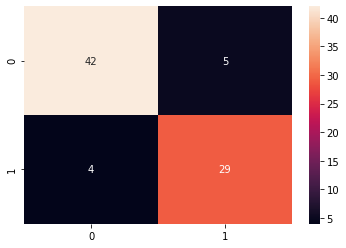

In [10]:
def plot_conf_mat(Y_pred, Y_gt):
    conf_mat = pd.DataFrame(confusion_matrix(Y_gt, Y_pred, labels=[0,1]))
    sn.heatmap(conf_mat, annot=True)
    
plot_conf_mat(Y_pred, Y_test)

In [11]:
if __name__ == "__main__":
    torch.save(model.state_dict(), "suv_predictor.pt")